# FAANG's Stock Market Performance
By Alvaro Rodriguez

## Business Understanding

## Data Understanding

## Data Preparation

Stock market performance analysis includes calulating close stock prices, moving averages, and measuring volatility

### Collect Real-Time Stock Market Data
Using the yfinance API, the data can be collected straight from Yahoo finance.

In [1]:
import pandas as pd
import yfinance as yf
from datetime import datetime

In [4]:
import pandas as pd
import numpy as np

import yfinance as yf
from matplotlib import pyplot as plt

import seaborn as sns
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
import itertools
import numpy as np
from joblib import Parallel, delayed
from matplotlib.ticker import StrMethodFormatter

In [5]:
# Start date of the stock price 12 months ago to current date
start_date = datetime.now() - pd.DateOffset(months=12)
end_date = datetime.now()

In [6]:
# Download the historical stock price data for FAANG for the last year
tickers = ['META', 'AAPL', 'AMZN', 'NFLX', 'GOOG']

df_list = []

for ticker in tickers:
    data = yf.download(ticker, start=start_date, end=end_date)
    df_list.append(data)

df = pd.concat(df_list, keys=tickers, names=['Ticker', 'Date'])
print(df.head())

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
                         Open        High         Low       Close   Adj Close   
Ticker Date                                                                     
META   2022-05-25  180.399994  185.449997  179.320007  183.830002  183.830002  \
       2022-05-26  182.880005  192.830002  182.259995  191.630005  191.630005   
       2022-05-27  191.360001  195.330002  189.800003  195.130005  195.130005   
       2022-05-31  194.889999  197.600006  192.009995  193.639999  193.639999   
       2022-06-01  196.509995  199.529999  185.000000  188.639999  188.639999   

                     Volume  
Ticker Date                  
META   2022-05-25  28030200

### Dataframe Information

In [7]:
df

Open        High         Low       Close   Adj Close   
Ticker Date                                                                     
META   2022-05-25  180.399994  185.449997  179.320007  183.830002  183.830002  \
       2022-05-26  182.880005  192.830002  182.259995  191.630005  191.630005   
       2022-05-27  191.360001  195.330002  189.800003  195.130005  195.130005   
       2022-05-31  194.889999  197.600006  192.009995  193.639999  193.639999   
       2022-06-01  196.509995  199.529999  185.000000  188.639999  188.639999   
...                       ...         ...         ...         ...         ...   
GOOG   2023-05-19  124.199997  126.478996  122.720001  123.250000  123.250000   
       2023-05-22  123.510002  127.050003  123.449997  125.870003  125.870003   
       2023-05-23  124.930000  125.419998  123.050003  123.290001  123.290001   
       2023-05-24  121.879997  122.750000  120.750000  121.639999  121.639999   
       2023-05-25  125.209999  125.980003  122.900002  124.349998  124.349998   

                     Volume  
Ticker Date                  
META   2022-05-25  28030200  
       2022-05-26  23056500  
       2022-05-27  22562700  
       2022-05-31  26131100  
       2022-06-01  36623500  
...                     ...  
GOOG   2023-05-19  30251300  
       2023-05-22  29760200  
       2023-05-23  24477900  
       2023-05-24  23087900  
       2023-05-25  33573836  

[1260 rows x 6 columns]

In [8]:
df.head()

Open        High         Low       Close   Adj Close   
Ticker Date                                                                     
META   2022-05-25  180.399994  185.449997  179.320007  183.830002  183.830002  \
       2022-05-26  182.880005  192.830002  182.259995  191.630005  191.630005   
       2022-05-27  191.360001  195.330002  189.800003  195.130005  195.130005   
       2022-05-31  194.889999  197.600006  192.009995  193.639999  193.639999   
       2022-06-01  196.509995  199.529999  185.000000  188.639999  188.639999   

                     Volume  
Ticker Date                  
META   2022-05-25  28030200  
       2022-05-26  23056500  
       2022-05-27  22562700  
       2022-05-31  26131100  
       2022-06-01  36623500

In [9]:
df.tail()

Open        High         Low       Close   Adj Close   
Ticker Date                                                                     
GOOG   2023-05-19  124.199997  126.478996  122.720001  123.250000  123.250000  \
       2023-05-22  123.510002  127.050003  123.449997  125.870003  125.870003   
       2023-05-23  124.930000  125.419998  123.050003  123.290001  123.290001   
       2023-05-24  121.879997  122.750000  120.750000  121.639999  121.639999   
       2023-05-25  125.209999  125.980003  122.900002  124.349998  124.349998   

                     Volume  
Ticker Date                  
GOOG   2023-05-19  30251300  
       2023-05-22  29760200  
       2023-05-23  24477900  
       2023-05-24  23087900  
       2023-05-25  33573836

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1260 entries, ('META', Timestamp('2022-05-25 00:00:00')) to ('GOOG', Timestamp('2023-05-25 00:00:00'))
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       1260 non-null   float64
 1   High       1260 non-null   float64
 2   Low        1260 non-null   float64
 3   Close      1260 non-null   float64
 4   Adj Close  1260 non-null   float64
 5   Volume     1260 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 73.1+ KB


In [11]:
df.describe()

Open         High          Low        Close    Adj Close   
count  1260.000000  1260.000000  1260.000000  1260.000000  1260.000000  \
mean    160.580976   163.408557   158.253320   160.940811   160.838903   
std      70.522479    71.880716    69.387643    70.725872    70.742116   
min      82.800003    83.480003    81.430000    81.820000    81.820000   
25%     107.578625   109.350126   105.970001   108.205000   108.205000   
50%     141.165001   143.130005   138.849998   141.334999   140.780045   
75%     179.590004   183.797501   176.747498   180.207500   180.207500   
max     372.410004   379.429993   363.809998   371.290009   371.290009   

             Volume  
count  1.260000e+03  
mean   4.285534e+07  
std    3.164961e+07  
min    2.657900e+06  
25%    1.942345e+07  
50%    3.321210e+07  
75%    6.414465e+07  
max    2.323166e+08

In [12]:
df.columns

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

In [13]:
df.index

MultiIndex([('META', '2022-05-25'),
            ('META', '2022-05-26'),
            ('META', '2022-05-27'),
            ('META', '2022-05-31'),
            ('META', '2022-06-01'),
            ('META', '2022-06-02'),
            ('META', '2022-06-03'),
            ('META', '2022-06-06'),
            ('META', '2022-06-07'),
            ('META', '2022-06-08'),
            ...
            ('GOOG', '2023-05-12'),
            ('GOOG', '2023-05-15'),
            ('GOOG', '2023-05-16'),
            ('GOOG', '2023-05-17'),
            ('GOOG', '2023-05-18'),
            ('GOOG', '2023-05-19'),
            ('GOOG', '2023-05-22'),
            ('GOOG', '2023-05-23'),
            ('GOOG', '2023-05-24'),
            ('GOOG', '2023-05-25')],
           names=['Ticker', 'Date'], length=1260)

In [14]:
df.shape

(1260, 6)

In [15]:
# Date column is in the index column in the DataFrame
df = df.reset_index()
df

Ticker       Date        Open        High         Low       Close   
0      META 2022-05-25  180.399994  185.449997  179.320007  183.830002  \
1      META 2022-05-26  182.880005  192.830002  182.259995  191.630005   
2      META 2022-05-27  191.360001  195.330002  189.800003  195.130005   
3      META 2022-05-31  194.889999  197.600006  192.009995  193.639999   
4      META 2022-06-01  196.509995  199.529999  185.000000  188.639999   
...     ...        ...         ...         ...         ...         ...   
1255   GOOG 2023-05-19  124.199997  126.478996  122.720001  123.250000   
1256   GOOG 2023-05-22  123.510002  127.050003  123.449997  125.870003   
1257   GOOG 2023-05-23  124.930000  125.419998  123.050003  123.290001   
1258   GOOG 2023-05-24  121.879997  122.750000  120.750000  121.639999   
1259   GOOG 2023-05-25  125.209999  125.980003  122.900002  124.349998   

       Adj Close    Volume  
0     183.830002  28030200  
1     191.630005  23056500  
2     195.130005  22562700  
3     193.639999  26131100  
4     188.639999  36623500  
...          ...       ...  
1255  123.250000  30251300  
1256  125.870003  29760200  
1257  123.290001  24477900  
1258  121.639999  23087900  
1259  124.349998  33573836  

[1260 rows x 8 columns]

### Plot Stock Market Performance

In [16]:
# Performance in the Stock Market of all the companies
import plotly.express as px
fig = px.line(df, x='Date',
             y='Close',
             color='Ticker',
             title="Stock Market Performance of FANNG for the Last Year")
fig.show();

In [17]:
# Faceted area chart of the companies to compare the performance of different companies
fig = px.area(df, x='Date', y='Close', color='Ticker',
             facet_col='Ticker',
             labels={'Date':'Date', 'Close':'Closing Price', 'Ticker':'Company'},
             title='Stock Prices for FAANG')

fig.show();

### Analyze Moving Averages

In [18]:
# Analyze moving averages; provides a useful way to identify trends and patterns in each company's stock price movements over the year

df['MA10'] = df.groupby('Ticker')['Close'].rolling(window=10).mean().reset_index(0, drop=True)
df['MA20'] = df.groupby('Ticker')['Close'].rolling(window=20).mean().reset_index(0, drop=True)

for ticker, group in df.groupby('Ticker'):
    print(f'Moving Averages for {ticker}')
    print(group[['MA10', 'MA20']])

Moving Averages for AAPL
           MA10        MA20
252         NaN         NaN
253         NaN         NaN
254         NaN         NaN
255         NaN         NaN
256         NaN         NaN
..          ...         ...
499  173.219003  170.404001
500  173.289003  170.847501
501  173.268002  171.237000
502  173.096002  171.641000
503  173.020003  171.870000

[252 rows x 2 columns]
Moving Averages for AMZN
           MA10        MA20
504         NaN         NaN
505         NaN         NaN
506         NaN         NaN
507         NaN         NaN
508         NaN         NaN
..          ...         ...
751  111.958001  108.380001
752  112.876001  108.820001
753  113.713000  109.441001
754  114.369000  110.029501
755  114.651000  110.288501

[252 rows x 2 columns]
Moving Averages for GOOG
            MA10       MA20
1008         NaN        NaN
1009         NaN        NaN
1010         NaN        NaN
1011         NaN        NaN
1012         NaN        NaN
...          ...        ...
1255  116

In [19]:
for ticker, group in df.groupby('Ticker'):
    fig = px.line(group, x='Date', y=['Close', 'MA10', 'MA20'], 
                  title=f"{ticker} Moving Averages")
    fig.show()

The output shows four separate graphs for each company in FAANG. When the MA10 crosses above the MA20, it is considered a bullish signal.
When the MA10 rosses below the MA20, it is considered a bearish signal.

### Analyze Volatility of Each Company in FAANG

In [20]:
# Analyze Volatility of each company
df['Volatility'] = df.groupby('Ticker')['Close'].pct_change().rolling(window=10).std().reset_index(0, drop=True)
fig = px.line(df, x='Date', y='Volatility', 
              color='Ticker', 
              title='Volatility of All Companies')
fig.show()

Volatility is the measure of how much and how often the stock price fluctuates over a given period of time. High volatility indicates that the stock experiences large and frequent price movements, while low volatility indicates that the market experiences smaller price movements.

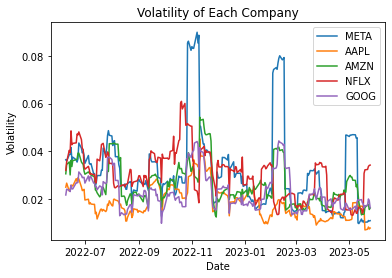

In [21]:
import matplotlib.pyplot as plt

# Analyze Volatility of each company
df['Volatility'] = df.groupby('Ticker')['Close'].pct_change().rolling(window=10).std().reset_index(0, drop=True)

# Iterate over each company
for ticker in df['Ticker'].unique():
    company_df = df[df['Ticker'] == ticker]
    volatility_values = company_df['Volatility'].to_numpy()  # Convert to NumPy array
    dates = company_df['Date'].to_numpy()  # Convert 'Date' column to NumPy array
    plt.plot(dates, volatility_values, label=ticker)

plt.title('Volatility of Each Company')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.legend()
plt.show();

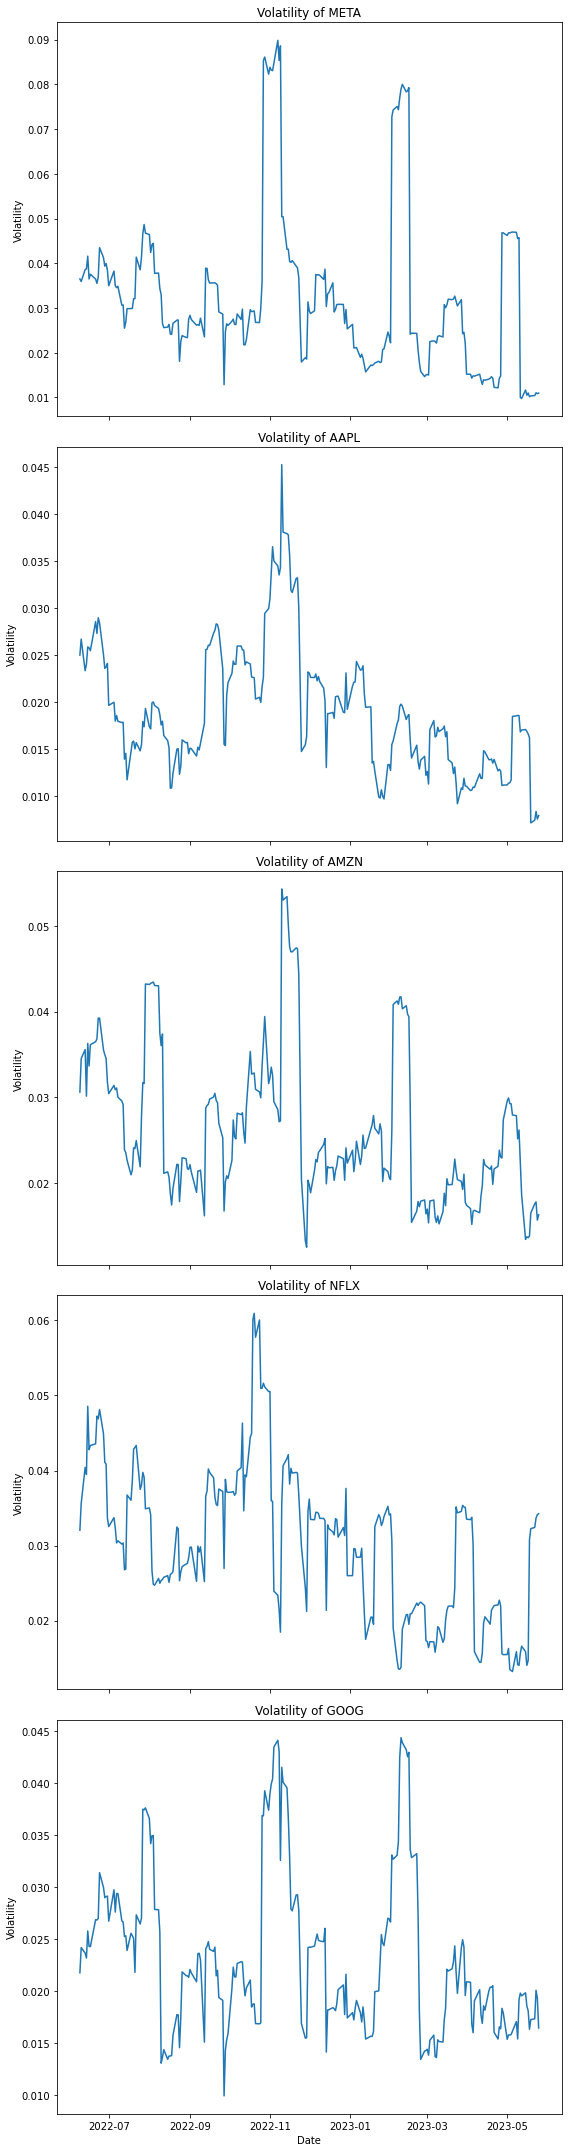

In [22]:
# Analyze Volatility of each company
df['Volatility'] = df.groupby('Ticker')['Close'].pct_change().rolling(window=10).std().reset_index(0, drop=True)

# Get unique tickers
tickers = df['Ticker'].unique()

# Determine the number of subplots based on the number of tickers
num_subplots = len(tickers)

# Create subplots
fig, axs = plt.subplots(num_subplots, 1, figsize=(8, 6*num_subplots), sharex=True)

# Iterate over each ticker and plot
for i, ticker in enumerate(tickers):
    company_df = df[df['Ticker'] == ticker]
    volatility_values = company_df['Volatility'].to_numpy()
    dates = company_df['Date'].to_numpy()
    
    # Select the appropriate subplot
    ax = axs[i] if num_subplots > 1 else axs
    
    # Plot the data
    ax.plot(dates, volatility_values)
    ax.set_title(f'Volatility of {ticker}')
    ax.set_ylabel('Volatility')

# Set the common x-axis label
axs[-1].set_xlabel('Date')

plt.tight_layout()
plt.show();

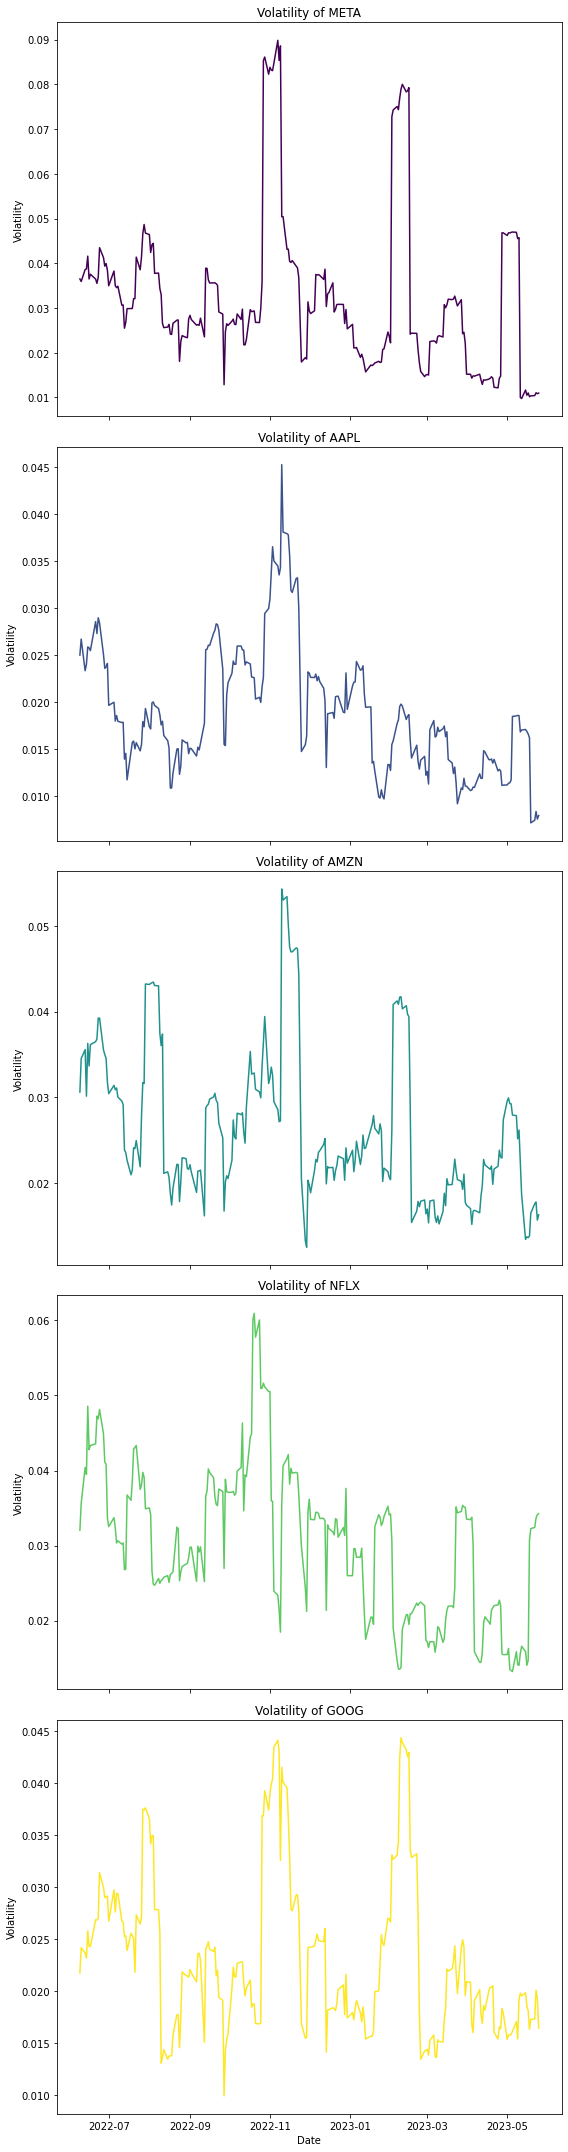

In [23]:
import numpy as np

# Analyze Volatility of each company
df['Volatility'] = df.groupby('Ticker')['Close'].pct_change().rolling(window=10).std().reset_index(0, drop=True)

# Get unique tickers
tickers = df['Ticker'].unique()

# Determine the number of subplots based on the number of tickers
num_subplots = len(tickers)

# Create a colormap using the 'viridis' color map
cmap = plt.get_cmap('viridis')
colors = cmap(np.linspace(0, 1, num_subplots))

# Create subplots
fig, axs = plt.subplots(num_subplots, 1, figsize=(8, 6*num_subplots), sharex=True)

# Iterate over each ticker and plot
for i, ticker in enumerate(tickers):
    company_df = df[df['Ticker'] == ticker]
    volatility_values = company_df['Volatility'].to_numpy()
    dates = company_df['Date'].to_numpy()
    
    # Select the appropriate subplot
    ax = axs[i] if num_subplots > 1 else axs
    
    # Plot the data with the corresponding color
    ax.plot(dates, volatility_values, color=colors[i])
    ax.set_title(f'Volatility of {ticker}')
    ax.set_ylabel('Volatility')

# Set the common x-axis label
axs[-1].set_xlabel('Date')

plt.tight_layout()
plt.show()

## Simple Model

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1260 entries, 0 to 1259
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Ticker      1260 non-null   object        
 1   Date        1260 non-null   datetime64[ns]
 2   Open        1260 non-null   float64       
 3   High        1260 non-null   float64       
 4   Low         1260 non-null   float64       
 5   Close       1260 non-null   float64       
 6   Adj Close   1260 non-null   float64       
 7   Volume      1260 non-null   int64         
 8   MA10        1215 non-null   float64       
 9   MA20        1165 non-null   float64       
 10  Volatility  1210 non-null   float64       
dtypes: datetime64[ns](1), float64(8), int64(1), object(1)
memory usage: 108.4+ KB


In [25]:
df.set_index('Date', inplace=True)

In [26]:
fig = px.line(df, x=df.index, y='Close', color='Ticker', title='Stock Prices Over Time')
fig.show();

### Time-Series Line Plot

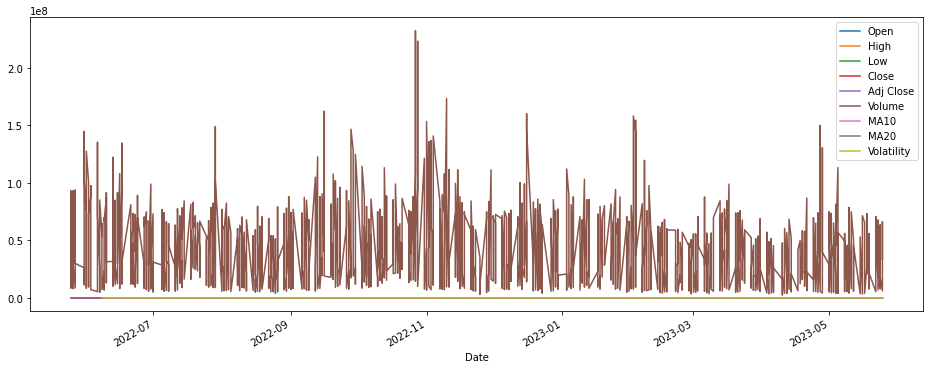

In [27]:
# Draw a line plot using df and .plot() method 
import matplotlib.pyplot as plt
%matplotlib inline

df.plot(figsize = (16,6));

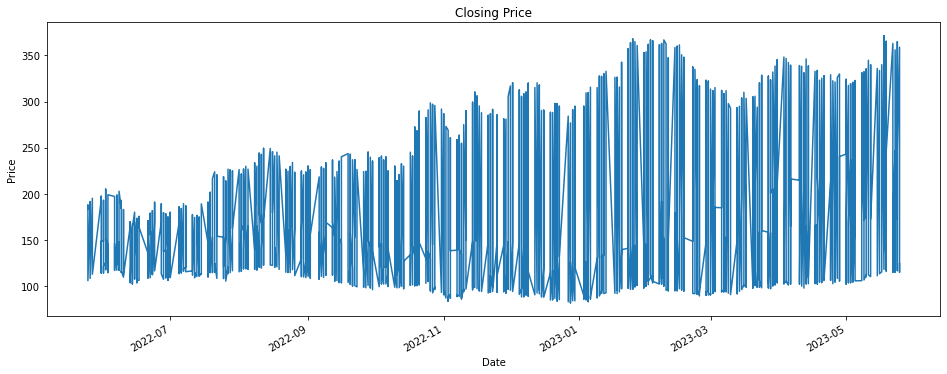

In [28]:
df['Close'].plot(figsize=(16, 6))
plt.title('Closing Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show();

### Time-series Dot Plot

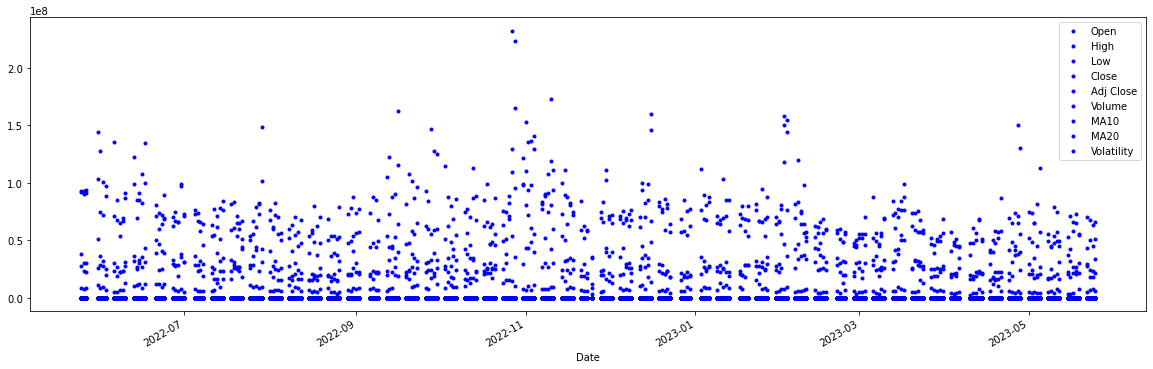

In [29]:
# Draw a dot plot using temp and .plot() method 
df.plot(figsize = (20,6), style = '.b');

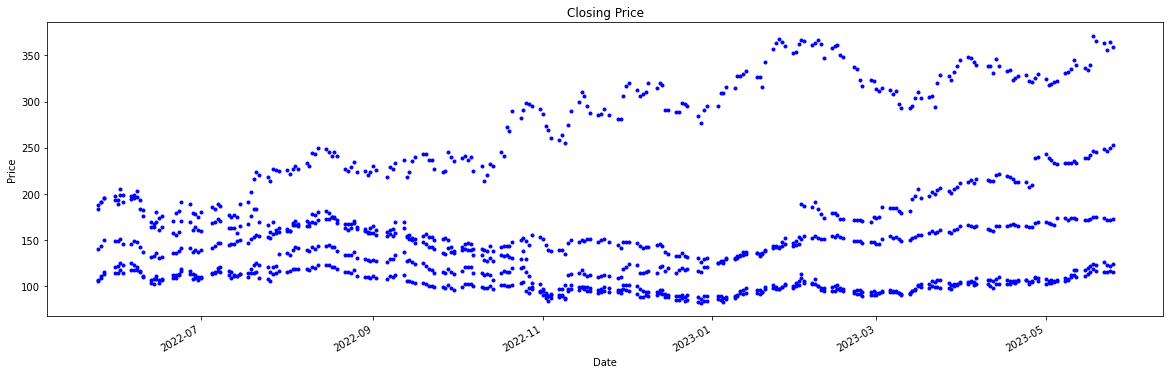

In [30]:
df['Close'].plot(figsize=(20, 6), style= '.b')
plt.title('Closing Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show();

### Separated Annual Yearly Percentage Change

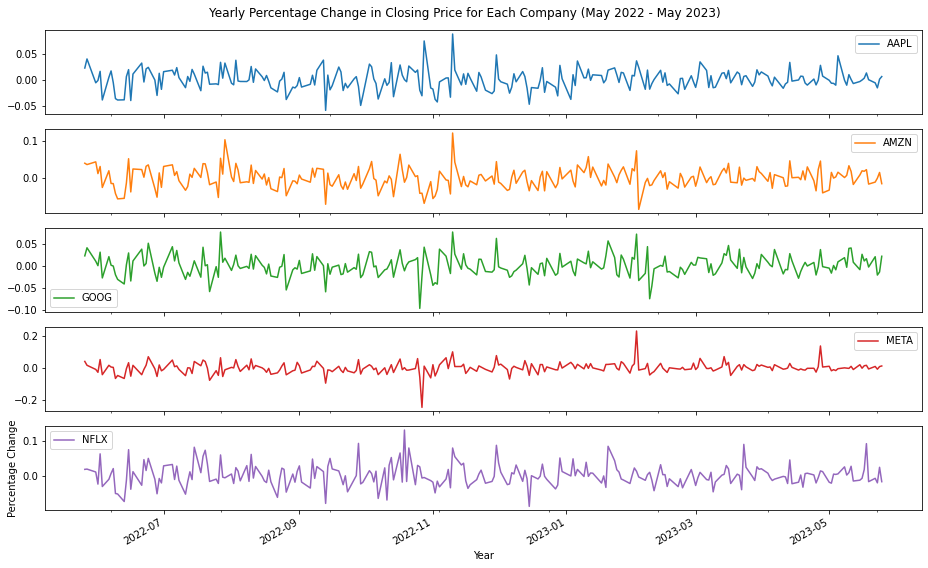

In [31]:
import pandas as pd

# Filter the DataFrame for the desired time range
start_date = pd.to_datetime('2022-05-01')
end_date = pd.to_datetime('2023-05-31')
df_filtered = df.loc[(df.index.get_level_values('Date') >= start_date) & (df.index.get_level_values('Date') <= end_date)]

# Group the filtered DataFrame by 'Ticker' column
groups = df_filtered.groupby('Ticker')

# Create a new DataFrame to store the annual percentage changes for each company
df_annual_pct_change = pd.DataFrame()

# Iterate over each group
for ticker, group in groups:
    # Calculate the percentage change of the closing prices
    pct_change = group['Close'].pct_change()
    # Align the length of values with the length of the index
    pct_change = pct_change.reindex(group.index.get_level_values('Date'))
    # Store the annual percentage changes in the new DataFrame
    df_annual_pct_change[ticker] = pct_change

# Plot the annual percentage changes as subplots
df_annual_pct_change.plot(figsize=(13, 8), subplots=True, legend=True)

# Set the plot title and labels
plt.suptitle('Yearly Percentage Change in Closing Price for Each Company (May 2022 - May 2023)')
plt.xlabel('Year')
plt.ylabel('Percentage Change')

# Adjust spacing between subplots
plt.tight_layout()

# Display the plot
plt.show();

### All Annual Together

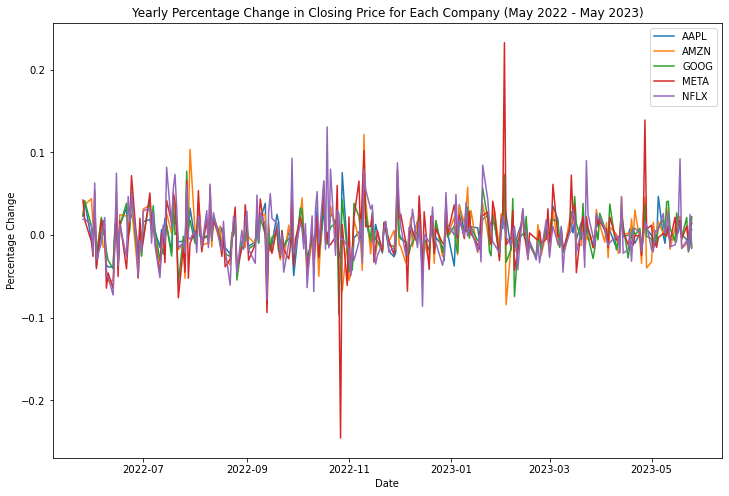

In [32]:
# Filter the DataFrame for the desired time range
start_date = pd.to_datetime('2022-05-01')
end_date = pd.to_datetime('2023-05-31')
df_filtered = df.loc[(df.index >= start_date) & (df.index <= end_date)]

# Group the filtered DataFrame by 'Ticker' column
groups = df_filtered.groupby('Ticker')

# Create a new DataFrame to store the annual percentage changes for each company
df_annual_pct_change = pd.DataFrame()

# Iterate over each group
for ticker, group in groups:
    # Calculate the percentage change of the closing prices
    pct_change = group['Close'].pct_change()
    # Align the length of values with the length of the index
    pct_change = pct_change.reindex(group.index)
    # Store the annual percentage changes in the new DataFrame
    df_annual_pct_change[ticker] = pct_change

# Plot the annual percentage changes
plt.figure(figsize=(12, 8))
for column in df_annual_pct_change.columns:
    plt.plot(df_annual_pct_change.index.to_numpy(), df_annual_pct_change[column].values, label=column)

# Set the plot title and labels
plt.title('Yearly Percentage Change in Closing Price for Each Company (May 2022 - May 2023)')
plt.xlabel('Date')
plt.ylabel('Percentage Change')
plt.legend()

# Display the plot
plt.show();

### Showing Distributions 
- Check for normality
- Check on raw and transformed data

In [33]:
df

Ticker        Open        High         Low       Close   Adj Close   
Date                                                                            
2022-05-25   META  180.399994  185.449997  179.320007  183.830002  183.830002  \
2022-05-26   META  182.880005  192.830002  182.259995  191.630005  191.630005   
2022-05-27   META  191.360001  195.330002  189.800003  195.130005  195.130005   
2022-05-31   META  194.889999  197.600006  192.009995  193.639999  193.639999   
2022-06-01   META  196.509995  199.529999  185.000000  188.639999  188.639999   
...           ...         ...         ...         ...         ...         ...   
2023-05-19   GOOG  124.199997  126.478996  122.720001  123.250000  123.250000   
2023-05-22   GOOG  123.510002  127.050003  123.449997  125.870003  125.870003   
2023-05-23   GOOG  124.930000  125.419998  123.050003  123.290001  123.290001   
2023-05-24   GOOG  121.879997  122.750000  120.750000  121.639999  121.639999   
2023-05-25   GOOG  125.209999  125.980003  122.900002  124.349998  124.349998   

              Volume        MA10       MA20  Volatility  
Date                                                     
2022-05-25  28030200         NaN        NaN         NaN  
2022-05-26  23056500         NaN        NaN         NaN  
2022-05-27  22562700         NaN        NaN         NaN  
2022-05-31  26131100         NaN        NaN         NaN  
2022-06-01  36623500         NaN        NaN         NaN  
...              ...         ...        ...         ...  
2023-05-19  30251300  116.857999  111.61225    0.017240  
2023-05-22  29760200  118.621000  112.56675    0.017309  
2023-05-23  24477900  120.156000  113.50075    0.020059  
2023-05-24  23087900  121.092000  114.36025    0.019294  
2023-05-25  33573836  121.837000  115.15925    0.016424  

[1260 rows x 10 columns]

### Histogram

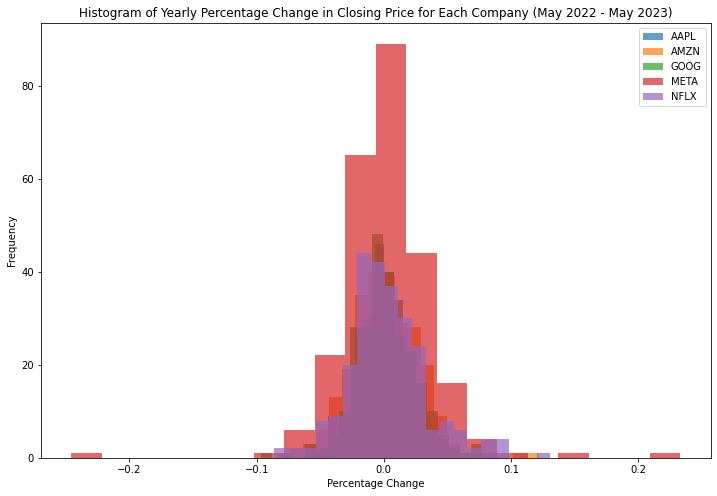

In [34]:
# Filter the DataFrame for the desired time range
start_date = pd.to_datetime('2022-05-01')
end_date = pd.to_datetime('2023-05-31')
df_filtered = df.loc[(df.index >= start_date) & (df.index <= end_date)]

# Group the filtered DataFrame by 'Ticker' column
groups = df_filtered.groupby('Ticker')

# Create a new DataFrame to store the annual percentage changes for each company
df_annual_pct_change = pd.DataFrame()

# Iterate over each group
for ticker, group in groups:
    # Calculate the percentage change of the closing prices
    pct_change = group['Close'].pct_change()
    # Align the length of values with the length of the index
    pct_change = pct_change.reindex(group.index)
    # Store the annual percentage changes in the new DataFrame
    df_annual_pct_change[ticker] = pct_change

# Plot a histogram for each company
plt.figure(figsize=(12, 8))
for column in df_annual_pct_change.columns:
    plt.hist(df_annual_pct_change[column].dropna(), bins=20, alpha=0.7, label=column)

# Set the plot title and labels
plt.title('Histogram of Yearly Percentage Change in Closing Price for Each Company (May 2022 - May 2023)')
plt.xlabel('Percentage Change')
plt.ylabel('Frequency')
plt.legend()

# Display the plot
plt.show();

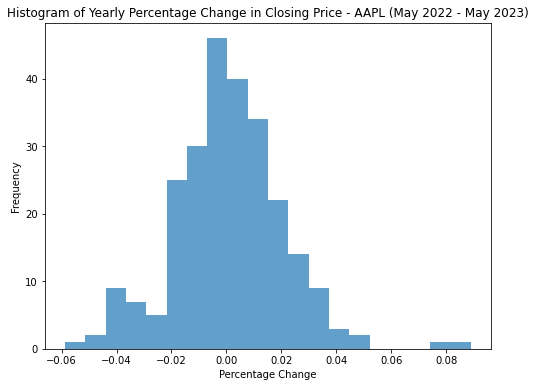

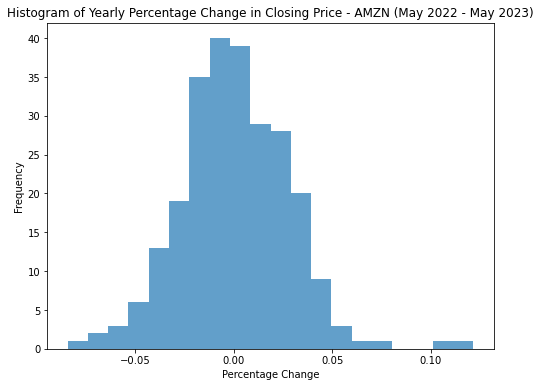

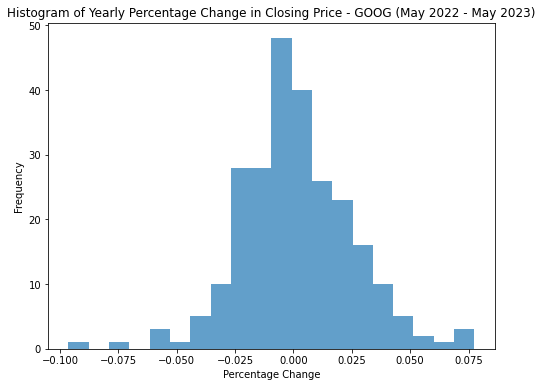

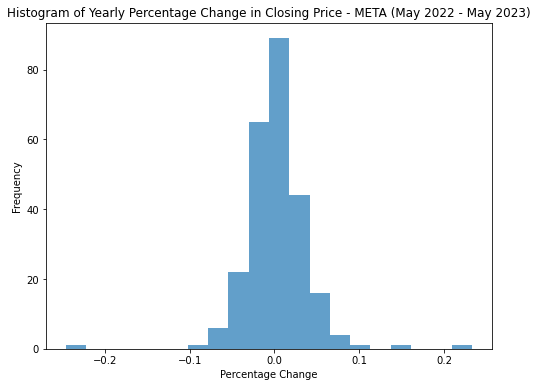

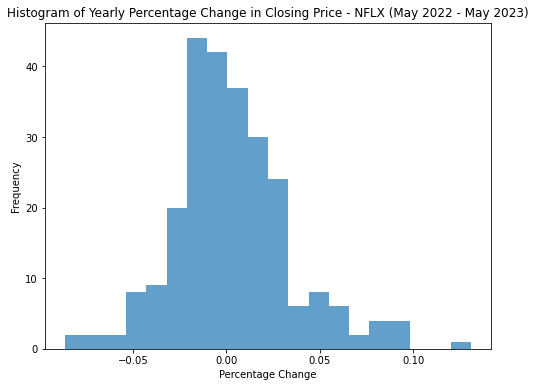

In [35]:
# Filter the DataFrame for the desired time range
start_date = pd.to_datetime('2022-05-01')
end_date = pd.to_datetime('2023-05-31')
df_filtered = df.loc[(df.index >= start_date) & (df.index <= end_date)]

# Group the filtered DataFrame by 'Ticker' column
groups = df_filtered.groupby('Ticker')

# Iterate over each group and create separate histograms
for ticker, group in groups:
    # Calculate the percentage change of the closing prices
    pct_change = group['Close'].pct_change()
    # Align the length of values with the length of the index
    pct_change = pct_change.reindex(group.index)
    
    # Plot a histogram for the current company
    plt.figure(figsize=(8, 6))
    plt.hist(pct_change.dropna(), bins=20, alpha=0.7)
    
    # Set the plot title and labels
    plt.title(f'Histogram of Yearly Percentage Change in Closing Price - {ticker} (May 2022 - May 2023)')
    plt.xlabel('Percentage Change')
    plt.ylabel('Frequency')
    
    # Display the plot for the current company
    plt.show();

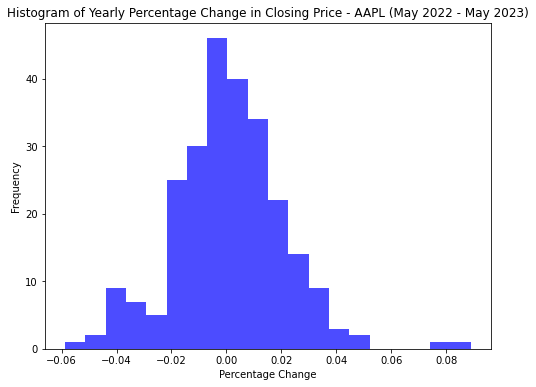

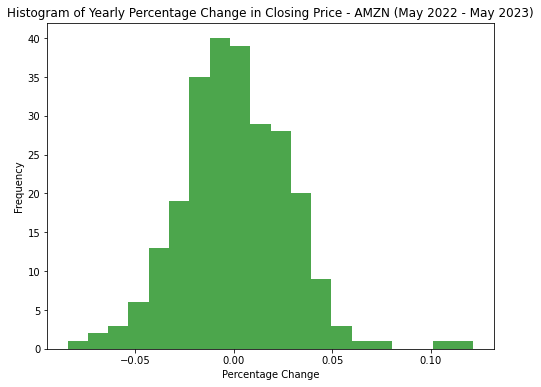

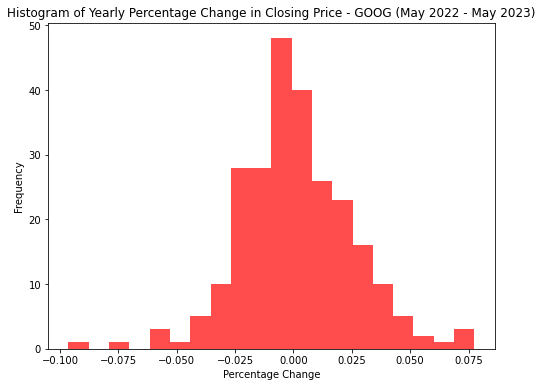

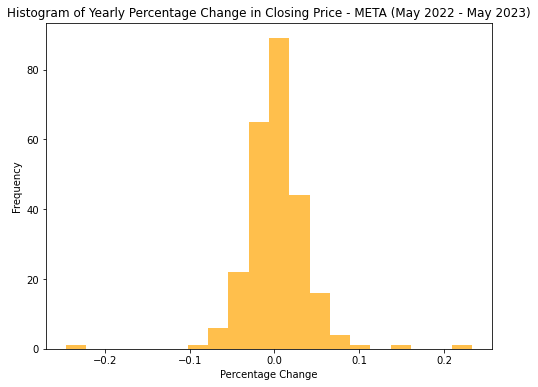

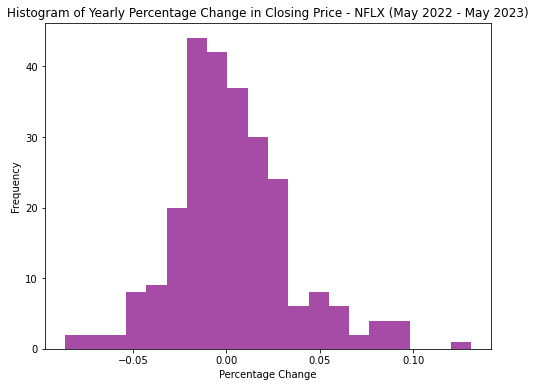

In [36]:
# Filter the DataFrame for the desired time range
start_date = pd.to_datetime('2022-05-01')
end_date = pd.to_datetime('2023-05-31')
df_filtered = df.loc[(df.index >= start_date) & (df.index <= end_date)]

# Group the filtered DataFrame by 'Ticker' column
groups = df_filtered.groupby('Ticker')

# Define a list of colors for each histogram
colors = ['blue', 'green', 'red', 'orange', 'purple']  # Add more colors if needed

# Iterate over each group and create separate histograms
for i, (ticker, group) in enumerate(groups):
    # Calculate the percentage change of the closing prices
    pct_change = group['Close'].pct_change()
    # Align the length of values with the length of the index
    pct_change = pct_change.reindex(group.index)
    
    # Plot a histogram for the current company with the specified color
    plt.figure(figsize=(8, 6))
    plt.hist(pct_change.dropna(), bins=20, alpha=0.7, color=colors[i % len(colors)])
    
    # Set the plot title and labels
    plt.title(f'Histogram of Yearly Percentage Change in Closing Price - {ticker} (May 2022 - May 2023)')
    plt.xlabel('Percentage Change')
    plt.ylabel('Frequency')
    
    # Display the plot for the current company
    plt.show();

The histogram illustrates the distribution of yearly percentage changes in the closing prices of different companies' stocks within the specified time range (May 2022 - May 2023). Each histogram represents a specific company, identified by its ticker symbol. 

The x-axis of the histogram represents the range of percentage changes, while the y-axis represents the frequency or count of occurrences for each range. The histogram is divided into bins, where each bin represents a range of percentage changes. The height of each bar in the histogram indicates the number of instances falling within that range.

By analyzing the histogram, we can gain insights into the volatility and distribution of price changes for each company during the given period. A wider and more spread-out distribution suggests higher price volatility, while a narrower distribution indicates more stable price behavior. Additionally, we can identify any patterns or outliers in the data that might be worth investigating further.

In [37]:
import seaborn as sns
import numpy as np
from scipy.stats import gaussian_kde

### Density Plot 

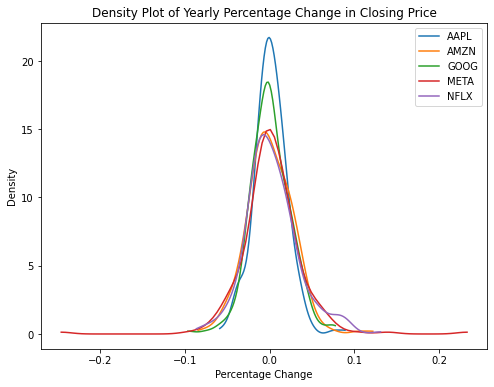

In [38]:
# Filter the DataFrame for the desired time range
start_date = pd.to_datetime('2022-05-01')
end_date = pd.to_datetime('2023-05-31')
df_filtered = df.loc[(df.index >= start_date) & (df.index <= end_date)]

# Group the filtered DataFrame by 'Ticker' column
groups = df_filtered.groupby('Ticker')

# Set up the figure and axis
fig, ax = plt.subplots(figsize=(8, 6))

# Iterate over each group and create separate density plots
for ticker, group in groups:
    # Calculate the percentage change of the closing prices
    pct_change = group['Close'].pct_change()
    # Align the length of values with the length of the index
    pct_change = pct_change.reindex(group.index)

    # Compute the kernel density estimate
    kde = gaussian_kde(pct_change.dropna())

    # Generate x-values for the density plot
    x = np.linspace(pct_change.min(), pct_change.max(), num=100)

    # Plot the density line for the current company
    ax.plot(x, kde(x), label=ticker)

# Set the plot title and labels
ax.set_title('Density Plot of Yearly Percentage Change in Closing Price')
ax.set_xlabel('Percentage Change')
ax.set_ylabel('Density')

# Add a legend
ax.legend()

# Display the plot
plt.show();

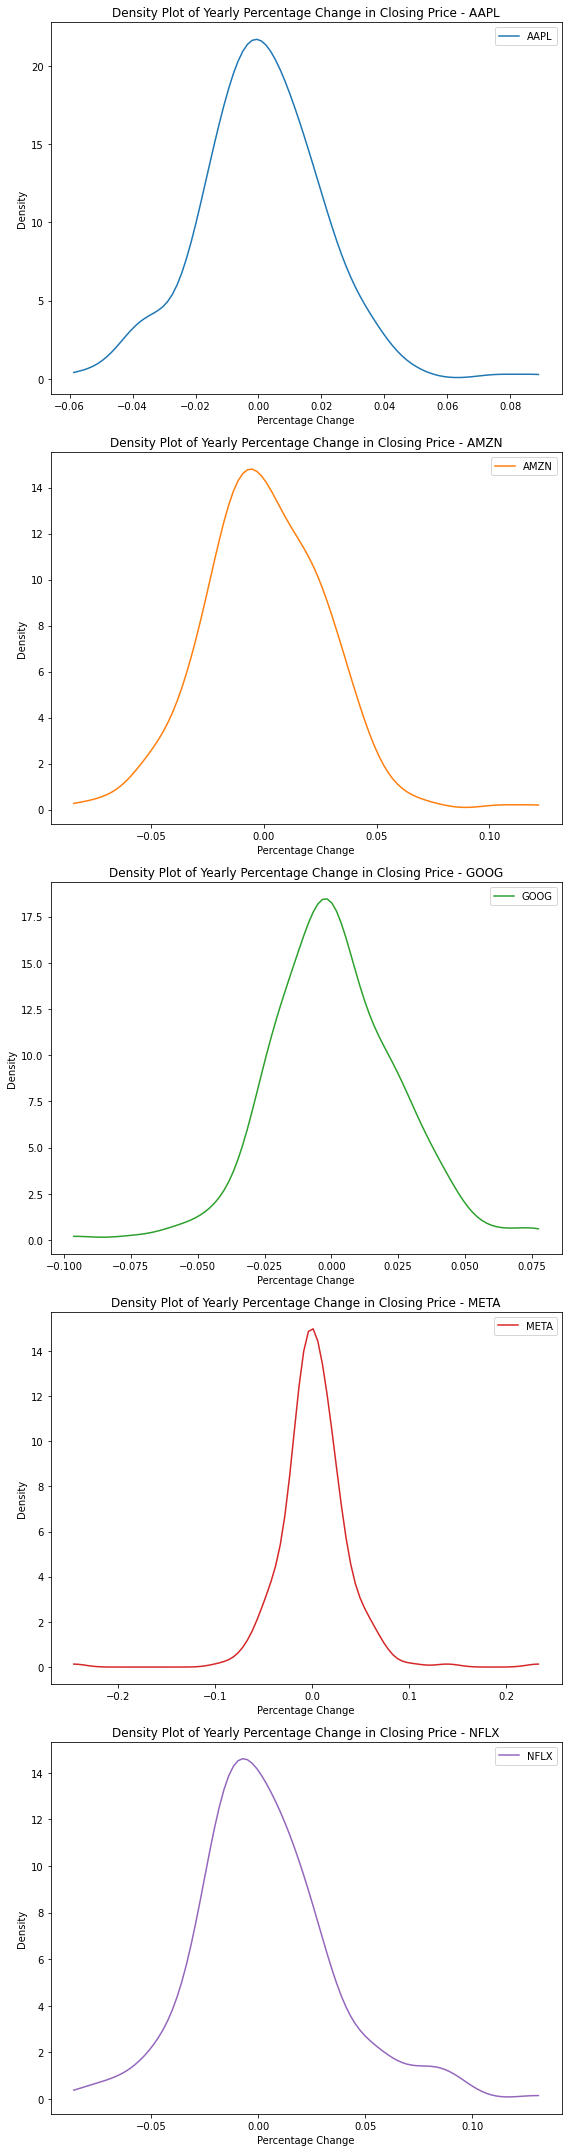

In [39]:
import numpy as np
from scipy.stats import gaussian_kde

start_date = pd.to_datetime('2022-05-01')
end_date = pd.to_datetime('2023-05-31')
df_filtered = df.loc[(df.index >= start_date) & (df.index <= end_date)]

groups = df_filtered.groupby('Ticker')

# Determine the number of groups
num_groups = len(groups)

# Set up the figure and subplots
fig, axes = plt.subplots(num_groups, 1, figsize=(8, 6*num_groups))

# Iterate over each group and create separate density plots
for i, (ticker, group) in enumerate(groups):
    pct_change = group['Close'].pct_change()
    pct_change = pct_change.reindex(group.index)

    kde = gaussian_kde(pct_change.dropna())

    x = np.linspace(pct_change.min(), pct_change.max(), num=100)

    # Use a different color for each group
    color = plt.cm.tab10(i)

    # Plot the density line for the current company on its own subplot
    ax = axes[i] if num_groups > 1 else axes
    ax.plot(x, kde(x), color=color, label=ticker)

    # Set the subplot title and labels
    ax.set_title(f'Density Plot of Yearly Percentage Change in Closing Price - {ticker}')
    ax.set_xlabel('Percentage Change')
    ax.set_ylabel('Density')

    # Add a legend to each subplot
    ax.legend()

# Adjust spacing between subplots
plt.tight_layout()

# Display the plot
plt.show();

### Box Plot
- Shows distributiions of the closing price of each company in FAANG

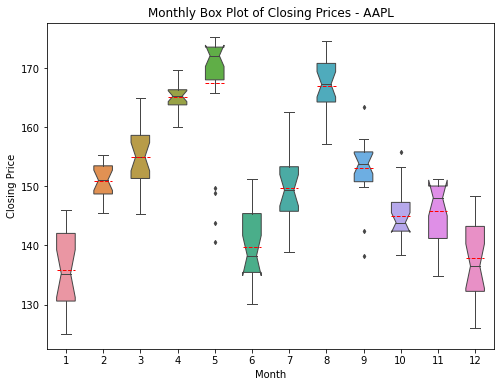

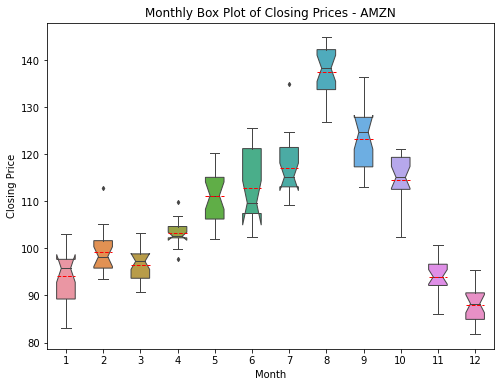

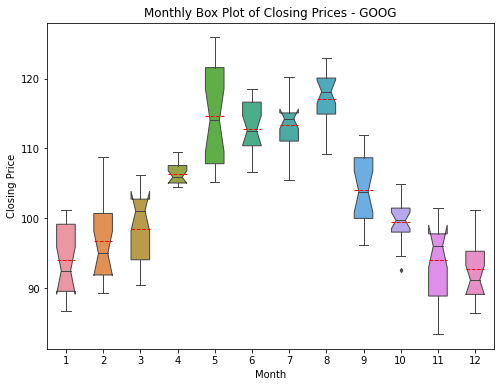

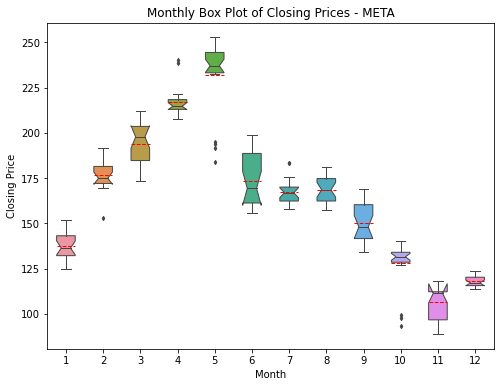

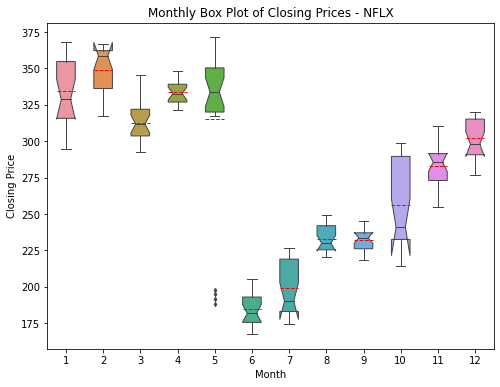

In [40]:
# Set the desired time range
start_date = pd.to_datetime('2022-05-01')
end_date = pd.to_datetime('2023-05-31')

# Filter the DataFrame for the desired time range
df_filtered = df.loc[(df.index >= start_date) & (df.index <= end_date)]

# Group the filtered DataFrame by 'Ticker'
groups = df_filtered.groupby('Ticker')

# Iterate over each group and create a separate box plot for each company
for ticker, group in groups:
    # Create a new figure and axis for each company
    fig, ax = plt.subplots(figsize=(8, 6))

    # Extract the closing prices for the current company
    closing_prices = group['Close']

    # Create the box plot for the current company
    sns.boxplot(x=group.index.month, y=closing_prices, ax=ax, width=0.5, linewidth=1, fliersize=3, whis=1.5, notch=True, showfliers=True, showmeans=True, meanline=True, meanprops={'color': 'red', 'linestyle': '--'})

    # Set the plot title and labels
    ax.set_title(f'Monthly Box Plot of Closing Prices - {ticker}')
    ax.set_xlabel('Month')
    ax.set_ylabel('Closing Price')

    # Display the plot
    plt.show();

### Heat Maps

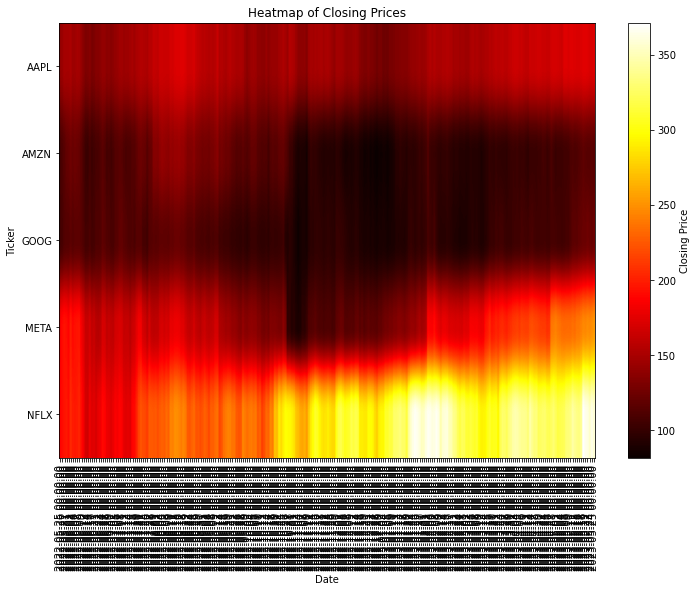

In [41]:
# Set the desired time range
start_date = pd.to_datetime('2022-05-01')
end_date = pd.to_datetime('2023-05-31')

# Filter the DataFrame for the desired time range
df_filtered = df.loc[(df.index >= start_date) & (df.index <= end_date)]

# Pivot the DataFrame to have 'Ticker' as columns and 'Date' as index
pivot_df = df_filtered.pivot(columns='Ticker', values='Close')

# Create the heatmap
plt.figure(figsize=(12, 8))
plt.imshow(pivot_df.values.T, cmap='hot', aspect='auto')

# Set the tick labels and positions
plt.xticks(range(len(pivot_df.index)), pivot_df.index, rotation=90)
plt.yticks(range(len(pivot_df.columns)), pivot_df.columns)

# Set the colorbar
plt.colorbar(label='Closing Price')

# Set the plot title and labels
plt.title('Heatmap of Closing Prices')
plt.xlabel('Date')
plt.ylabel('Ticker')

# Show the plot
plt.show();

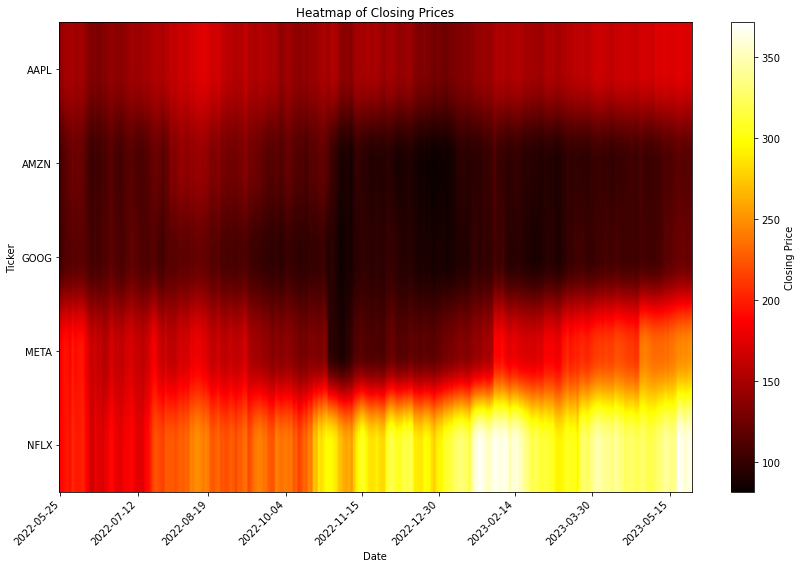

In [42]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Set the desired time range
start_date = pd.to_datetime('2022-05-01')
end_date = pd.to_datetime('2023-05-31')

# Filter the DataFrame for the desired time range
df_filtered = df.loc[(df.index >= start_date) & (df.index <= end_date)]

# Pivot the DataFrame to have 'Ticker' as columns and 'Date' as index
pivot_df = df_filtered.pivot(columns='Ticker', values='Close')

# Create the heatmap
fig, ax = plt.subplots(figsize=(12, 8))
im = ax.imshow(pivot_df.values.T, cmap='hot', aspect='auto')

# Set the x-axis tick labels and positions
x_ticks = range(len(pivot_df.index))
x_tick_labels = pivot_df.index.strftime('%Y-%m-%d')  # Format dates as desired
ax.set_xticks(x_ticks)
ax.set_xticklabels(x_tick_labels, rotation=45, ha='right')
ax.xaxis.set_major_locator(mdates.MonthLocator())  # Adjust tick frequency if needed

# Set the y-axis tick labels and positions
y_ticks = range(len(pivot_df.columns))
y_tick_labels = pivot_df.columns
ax.set_yticks(y_ticks)
ax.set_yticklabels(y_tick_labels)

# Set the colorbar
plt.colorbar(im, label='Closing Price')

# Set the plot title and labels
plt.title('Heatmap of Closing Prices')
plt.xlabel('Date')
plt.ylabel('Ticker')

# Show the plot
plt.tight_layout()  # Ensure labels are not cut off
plt.show();

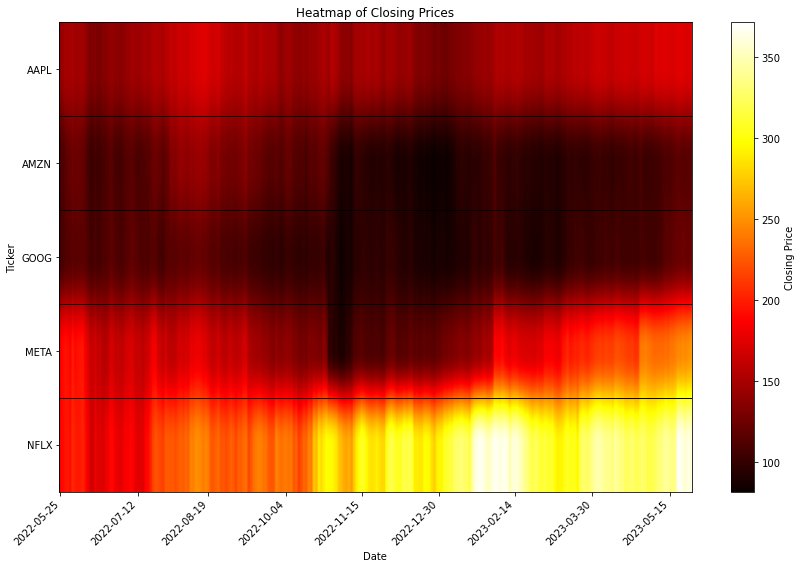

In [43]:
from matplotlib.patches import Rectangle

# Set the desired time range
start_date = pd.to_datetime('2022-05-01')
end_date = pd.to_datetime('2023-05-31')

# Filter the DataFrame for the desired time range
df_filtered = df.loc[(df.index >= start_date) & (df.index <= end_date)]

# Pivot the DataFrame to have 'Ticker' as columns and 'Date' as index
pivot_df = df_filtered.pivot(columns='Ticker', values='Close')

# Create the heatmap
fig, ax = plt.subplots(figsize=(12, 8))
im = ax.imshow(pivot_df.values.T, cmap='hot', aspect='auto')

# Set the x-axis tick labels and positions
x_ticks = range(len(pivot_df.index))
x_tick_labels = pivot_df.index.strftime('%Y-%m-%d')  # Format dates as desired
ax.set_xticks(x_ticks)
ax.set_xticklabels(x_tick_labels, rotation=45, ha='right')
ax.xaxis.set_major_locator(mdates.MonthLocator())  # Adjust tick frequency if needed

# Set the y-axis tick labels and positions
y_ticks = range(len(pivot_df.columns))
y_tick_labels = pivot_df.columns
ax.set_yticks(y_ticks)
ax.set_yticklabels(y_tick_labels)

# Add boxes for each company
for i in range(len(pivot_df.columns)):
    rect = Rectangle((-0.5, i - 0.5), len(pivot_df.index), 1, facecolor='none', edgecolor='black')
    ax.add_patch(rect)

# Set the colorbar
plt.colorbar(im, label='Closing Price')

# Set the plot title and labels
plt.title('Heatmap of Closing Prices')
plt.xlabel('Date')
plt.ylabel('Ticker')

# Show the plot
plt.tight_layout()  # Ensure labels are not cut off
plt.show();

### Check for Stationarity 

In [67]:
# Set the desired time range
start_date = pd.to_datetime('2022-05-01')
end_date = pd.to_datetime('2023-05-31')

# Filter the DataFrame for the desired time range
df_filtered_F = df.loc[(df.index >= start_date) & (df.index <= end_date)]

# Select the closing price of a specific company for the time series analysis
company_ticker = 'META'
time_series = df_filtered[df_filtered['Ticker'] == company_ticker]['Close']

# Perform the Augmented Dickey-Fuller test
result_F = adfuller(time_series)

print(result_F)

(-0.08397756678813963, 0.9510112293168292, 0, 251, {'1%': -3.4566744514553016, '5%': -2.8731248767783426, '10%': -2.5729436702592023}, 1476.8981809566537)


In [68]:
# Perform the Augmented Dickey-Fuller test
result = adfuller(time_series)

# Print the full result with labels
print("ADF Statistic:", result_F[0])
print("p-value:", result_F[1])
print("Critical Values:")
for key, value in result_F[4].items():
    print(f"{key} (at {value} critical value): {result_F[4][key]}")
print("Is Stationary:", result_F[1] < 0.05)

ADF Statistic: -0.08397756678813963
p-value: 0.9510112293168292
Critical Values:
1% (at -3.4566744514553016 critical value): -3.4566744514553016
5% (at -2.8731248767783426 critical value): -2.8731248767783426
10% (at -2.5729436702592023 critical value): -2.5729436702592023
Is Stationary: False


In [69]:
# Set the desired time range
start_date = pd.to_datetime('2022-05-01')
end_date = pd.to_datetime('2023-05-31')

# Filter the DataFrame for the desired time range
df_filtered_AP = df.loc[(df.index >= start_date) & (df.index <= end_date)]

# Select the closing price of a specific company for the time series analysis
company_ticker = 'AAPL'
time_series = df_filtered[df_filtered['Ticker'] == company_ticker]['Close']

# Perform the Augmented Dickey-Fuller test
result_AP = adfuller(time_series)
print(result_AP)

(-1.6004307698499853, 0.4833770754254152, 0, 251, {'1%': -3.4566744514553016, '5%': -2.8731248767783426, '10%': -2.5729436702592023}, 1161.9134106279025)


In [70]:
# Perform the Augmented Dickey-Fuller test
result_AP = adfuller(time_series)

# Print the full result with labels
print("ADF Statistic:", result_AP[0])
print("p-value:", result_AP[1])
print("Critical Values:")
for key, value in result_AP[4].items():
    print(f"{key} (at {value} critical value): {result_AP[4][key]}")
print("Is Stationary:", result_AP[1] < 0.05)

ADF Statistic: -1.6004307698499853
p-value: 0.4833770754254152
Critical Values:
1% (at -3.4566744514553016 critical value): -3.4566744514553016
5% (at -2.8731248767783426 critical value): -2.8731248767783426
10% (at -2.5729436702592023 critical value): -2.5729436702592023
Is Stationary: False


In [71]:
# Set the desired time range
start_date = pd.to_datetime('2022-05-01')
end_date = pd.to_datetime('2023-05-31')

# Filter the DataFrame for the desired time range
df_filtered_AM = df.loc[(df.index >= start_date) & (df.index <= end_date)]

# Select the closing price of a specific company for the time series analysis
company_ticker = 'AMZN'
time_series = df_filtered[df_filtered['Ticker'] == company_ticker]['Close']

# Perform the Augmented Dickey-Fuller test
result_AM = adfuller(time_series)
print(result_AM)

(-1.5608273069809186, 0.5032354859654384, 0, 251, {'1%': -3.4566744514553016, '5%': -2.8731248767783426, '10%': -2.5729436702592023}, 1173.145845691122)


In [72]:
# Perform the Augmented Dickey-Fuller test
result_AM = adfuller(time_series)

# Print the full result with labels
print("ADF Statistic:", result_AM[0])
print("p-value:", result_AM[1])
print("Critical Values:")
for key, value in result_AM[4].items():
    print(f"{key} (at {value} critical value): {result_AM[4][key]}")
print("Is Stationary:", result_AM[1] < 0.05)

ADF Statistic: -1.5608273069809186
p-value: 0.5032354859654384
Critical Values:
1% (at -3.4566744514553016 critical value): -3.4566744514553016
5% (at -2.8731248767783426 critical value): -2.8731248767783426
10% (at -2.5729436702592023 critical value): -2.5729436702592023
Is Stationary: False


In [73]:
# Set the desired time range
start_date = pd.to_datetime('2022-05-01')
end_date = pd.to_datetime('2023-05-31')

# Filter the DataFrame for the desired time range
df_filtered_N = df.loc[(df.index >= start_date) & (df.index <= end_date)]

# Select the closing price of a specific company for the time series analysis
company_ticker = 'NFLX'
time_series = df_filtered[df_filtered['Ticker'] == company_ticker]['Close']

# Perform the Augmented Dickey-Fuller test
result_N = adfuller(time_series)
print(result_N)

(-1.2244236999620313, 0.663002011181012, 0, 251, {'1%': -3.4566744514553016, '5%': -2.8731248767783426, '10%': -2.5729436702592023}, 1663.483767608698)


In [74]:
# Perform the Augmented Dickey-Fuller test
result_N = adfuller(time_series)

# Print the full result with labels
print("ADF Statistic:", result_N[0])
print("p-value:", result_N[1])
print("Critical Values:")
for key, value in result_N[4].items():
    print(f"{key} (at {value} critical value): {result_N[4][key]}")
print("Is Stationary:", result_N[1] < 0.05)

ADF Statistic: -1.2244236999620313
p-value: 0.663002011181012
Critical Values:
1% (at -3.4566744514553016 critical value): -3.4566744514553016
5% (at -2.8731248767783426 critical value): -2.8731248767783426
10% (at -2.5729436702592023 critical value): -2.5729436702592023
Is Stationary: False


In [75]:
# Set the desired time range
start_date = pd.to_datetime('2022-05-01')
end_date = pd.to_datetime('2023-05-31')

# Filter the DataFrame for the desired time range
df_filtered_G = df.loc[(df.index >= start_date) & (df.index <= end_date)]

# Select the closing price of a specific company for the time series analysis
company_ticker = 'GOOG'
time_series = df_filtered[df_filtered['Ticker'] == company_ticker]['Close']

# Perform the Augmented Dickey-Fuller test
result_G = adfuller(time_series)
print(result_G)

(-1.4907880552888804, 0.538063334663326, 0, 251, {'1%': -3.4566744514553016, '5%': -2.8731248767783426, '10%': -2.5729436702592023}, 1096.2906862536654)


In [77]:
# Perform the Augmented Dickey-Fuller test
result_G = adfuller(time_series)

# Print the full result with labels
print("ADF Statistic:", result_G[0])
print("p-value:", result_G[1])
print("Critical Values:")
for key, value in result_G[4].items():
    print(f"{key} (at {value} critical value): {result_G[4][key]}")
print("Is Stationary:", result_G[1] < 0.05)

ADF Statistic: -1.4907880552888804
p-value: 0.538063334663326
Critical Values:
1% (at -3.4566744514553016 critical value): -3.4566744514553016
5% (at -2.8731248767783426 critical value): -2.8731248767783426
10% (at -2.5729436702592023 critical value): -2.5729436702592023
Is Stationary: False


### Log and Square Root Transformation

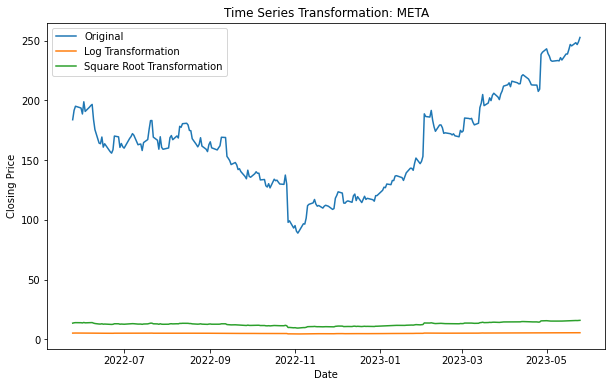

Augmented Dickey-Fuller Test: META (Original)
Test Statistic: -0.08397756678813963
P-value: 0.9510112293168292
Critical Values: {'1%': -3.4566744514553016, '5%': -2.8731248767783426, '10%': -2.5729436702592023}

Augmented Dickey-Fuller Test: META (Log Transformation)
Test Statistic: -0.5373801433696621
P-value: 0.8845133066718971
Critical Values: {'1%': -3.4566744514553016, '5%': -2.8731248767783426, '10%': -2.5729436702592023}

Augmented Dickey-Fuller Test: META (Square Root Transformation)
Test Statistic: -0.313014654413256
P-value: 0.9236407349981895
Critical Values: {'1%': -3.4566744514553016, '5%': -2.8731248767783426, '10%': -2.5729436702592023}



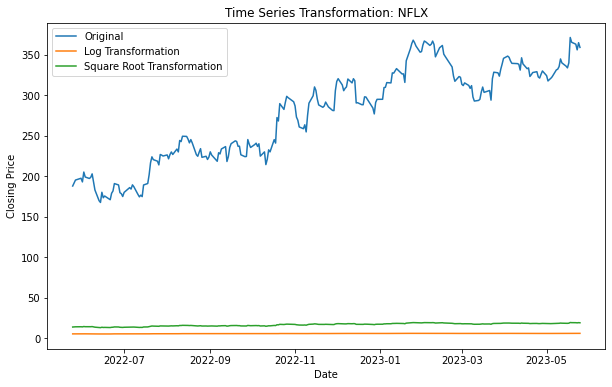

Augmented Dickey-Fuller Test: NFLX (Original)
Test Statistic: -1.2244236999620313
P-value: 0.663002011181012
Critical Values: {'1%': -3.4566744514553016, '5%': -2.8731248767783426, '10%': -2.5729436702592023}

Augmented Dickey-Fuller Test: NFLX (Log Transformation)
Test Statistic: -1.3801165246329612
P-value: 0.5917705185716103
Critical Values: {'1%': -3.4566744514553016, '5%': -2.8731248767783426, '10%': -2.5729436702592023}

Augmented Dickey-Fuller Test: NFLX (Square Root Transformation)
Test Statistic: -1.2974006649038576
P-value: 0.6303606719964235
Critical Values: {'1%': -3.4566744514553016, '5%': -2.8731248767783426, '10%': -2.5729436702592023}



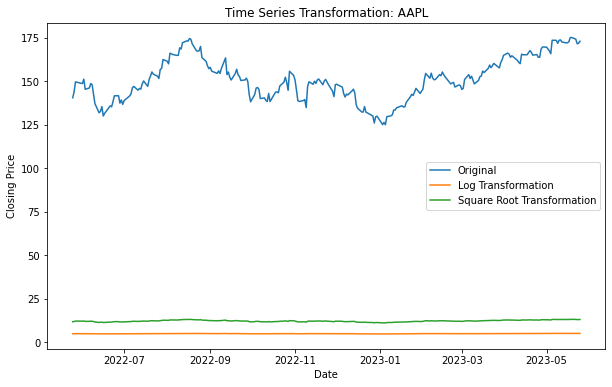

Augmented Dickey-Fuller Test: AAPL (Original)
Test Statistic: -1.6004307698499853
P-value: 0.4833770754254152
Critical Values: {'1%': -3.4566744514553016, '5%': -2.8731248767783426, '10%': -2.5729436702592023}

Augmented Dickey-Fuller Test: AAPL (Log Transformation)
Test Statistic: -1.6853700704482841
P-value: 0.43866558199256067
Critical Values: {'1%': -3.4566744514553016, '5%': -2.8731248767783426, '10%': -2.5729436702592023}

Augmented Dickey-Fuller Test: AAPL (Square Root Transformation)
Test Statistic: -1.6423532737109234
P-value: 0.46103140508938745
Critical Values: {'1%': -3.4566744514553016, '5%': -2.8731248767783426, '10%': -2.5729436702592023}



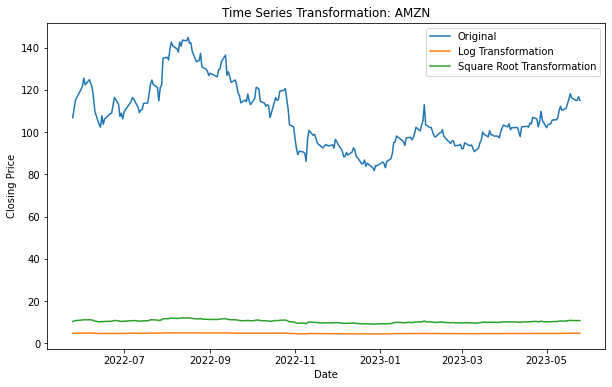

Augmented Dickey-Fuller Test: AMZN (Original)
Test Statistic: -1.5608273069809186
P-value: 0.5032354859654384
Critical Values: {'1%': -3.4566744514553016, '5%': -2.8731248767783426, '10%': -2.5729436702592023}

Augmented Dickey-Fuller Test: AMZN (Log Transformation)
Test Statistic: -1.558832784020486
P-value: 0.5042332034337323
Critical Values: {'1%': -3.4566744514553016, '5%': -2.8731248767783426, '10%': -2.5729436702592023}

Augmented Dickey-Fuller Test: AMZN (Square Root Transformation)
Test Statistic: -1.5569134834848783
P-value: 0.5051930309521453
Critical Values: {'1%': -3.4566744514553016, '5%': -2.8731248767783426, '10%': -2.5729436702592023}



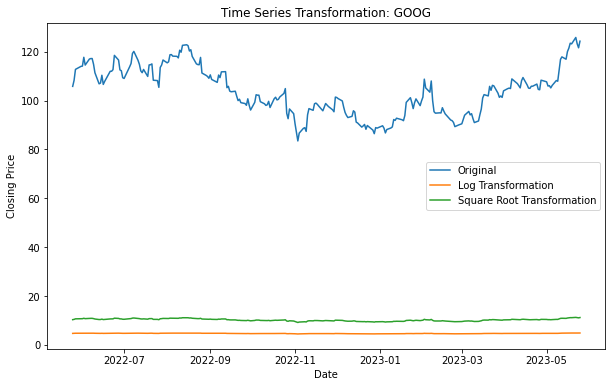

Augmented Dickey-Fuller Test: GOOG (Original)
Test Statistic: -1.4907880552888804
P-value: 0.538063334663326
Critical Values: {'1%': -3.4566744514553016, '5%': -2.8731248767783426, '10%': -2.5729436702592023}

Augmented Dickey-Fuller Test: GOOG (Log Transformation)
Test Statistic: -1.562198640203795
P-value: 0.5025493484226131
Critical Values: {'1%': -3.4566744514553016, '5%': -2.8731248767783426, '10%': -2.5729436702592023}

Augmented Dickey-Fuller Test: GOOG (Square Root Transformation)
Test Statistic: -1.525324219266421
P-value: 0.5209486964622965
Critical Values: {'1%': -3.4566744514553016, '5%': -2.8731248767783426, '10%': -2.5729436702592023}



In [81]:
# Set the desired time range
start_date = pd.to_datetime('2022-05-01')
end_date = pd.to_datetime('2023-05-31')

# Filter the DataFrame for the desired time range
df_filtered = df.loc[(df.index >= start_date) & (df.index <= end_date)]

# Define the list of company tickers
company_tickers = ['META', 'NFLX', 'AAPL', 'AMZN', "GOOG"]  # Replace with actual company tickers

# Iterate over each company ticker
for ticker in company_tickers:
    # Select the closing price of the current company for the time series analysis
    time_series = df_filtered[df_filtered['Ticker'] == ticker]['Close']
    
    # Perform the Augmented Dickey-Fuller test on the original series
    result_original = adfuller(time_series)
    
    # Perform the log transformation on the series
    log_transformed = np.log(time_series)
    
    # Perform the square root transformation on the series
    sqrt_transformed = np.sqrt(time_series)
    
    # Perform the Augmented Dickey-Fuller test on the log-transformed series
    result_log = adfuller(log_transformed)
    
    # Perform the Augmented Dickey-Fuller test on the square root-transformed series
    result_sqrt = adfuller(sqrt_transformed)
    
    # Plot the original, log-transformed, and square root-transformed series
    plt.figure(figsize=(10, 6))
    plt.plot(time_series, label='Original')
    plt.plot(log_transformed, label='Log Transformation')
    plt.plot(sqrt_transformed, label='Square Root Transformation')
    plt.title(f'Time Series Transformation: {ticker}')
    plt.xlabel('Date')
    plt.ylabel('Closing Price')
    plt.legend()
    plt.show()
    
    # Print the Augmented Dickey-Fuller test results
    print(f'Augmented Dickey-Fuller Test: {ticker} (Original)')
    print(f'Test Statistic: {result_original[0]}')
    print(f'P-value: {result_original[1]}')
    print(f'Critical Values: {result_original[4]}')
    print('')

    print(f'Augmented Dickey-Fuller Test: {ticker} (Log Transformation)')
    print(f'Test Statistic: {result_log[0]}')
    print(f'P-value: {result_log[1]}')
    print(f'Critical Values: {result_log[4]}')
    print('')

    print(f'Augmented Dickey-Fuller Test: {ticker} (Square Root Transformation)')
    print(f'Test Statistic: {result_sqrt[0]}')
    print(f'P-value: {result_sqrt[1]}')
    print(f'Critical Values: {result_sqrt[4]}')
    print('');

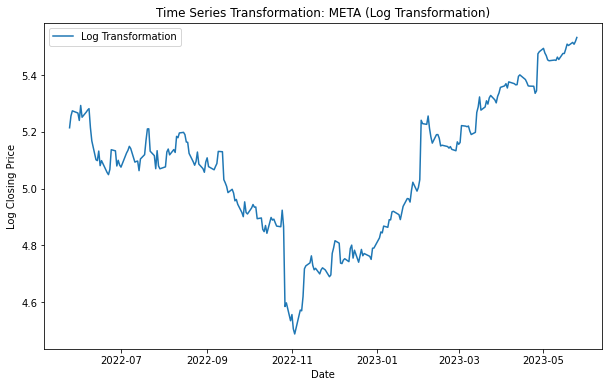

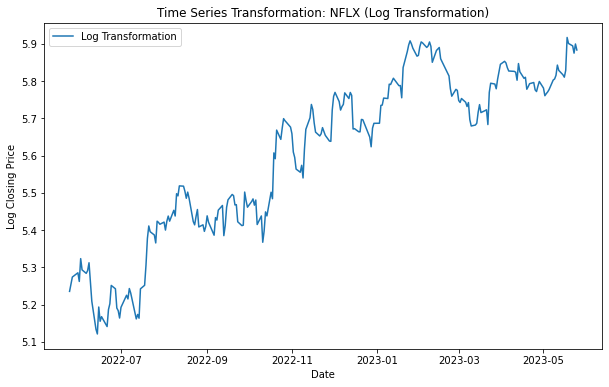

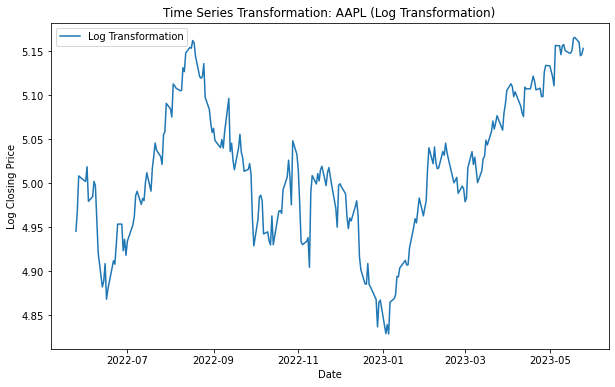

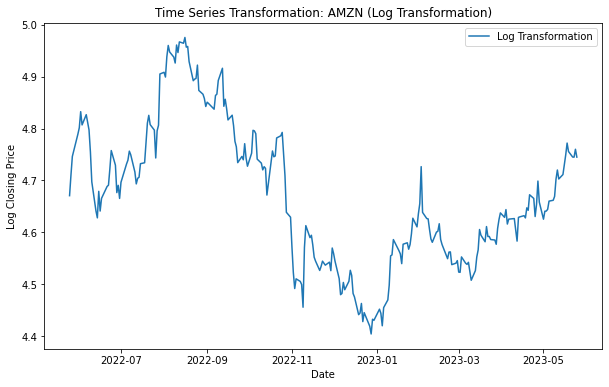

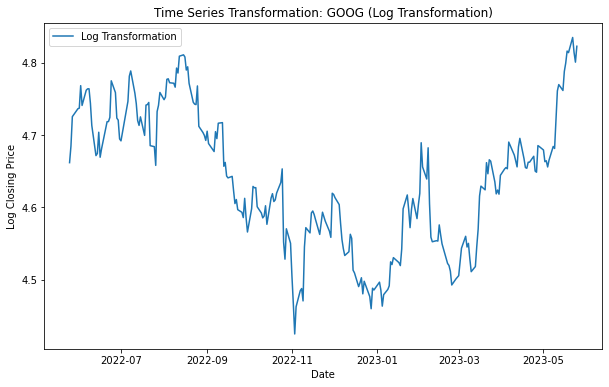

In [87]:
# Set the desired time range
start_date = pd.to_datetime('2022-05-01')
end_date = pd.to_datetime('2023-05-31')

# Filter the DataFrame for the desired time range
df_filtered = df.loc[(df.index >= start_date) & (df.index <= end_date)]

# Define the list of company tickers
company_tickers = ['META', 'NFLX', 'AAPL', 'AMZN', "GOOG"]  # Replace with actual company tickers

# Perform the log transformation for each company first
for ticker in company_tickers:
    # Select the closing price of the current company for the time series analysis
    time_series = df_filtered[df_filtered['Ticker'] == ticker]['Close']
    
    # Perform the log transformation on the series
    log_transformed = np.log(time_series)
    
    # Plot the log-transformed series
    plt.figure(figsize=(10, 6))
    plt.plot(log_transformed, label='Log Transformation')
    plt.title(f'Time Series Transformation: {ticker} (Log Transformation)')
    plt.xlabel('Date')
    plt.ylabel('Log Closing Price')
    plt.legend()
    plt.show();

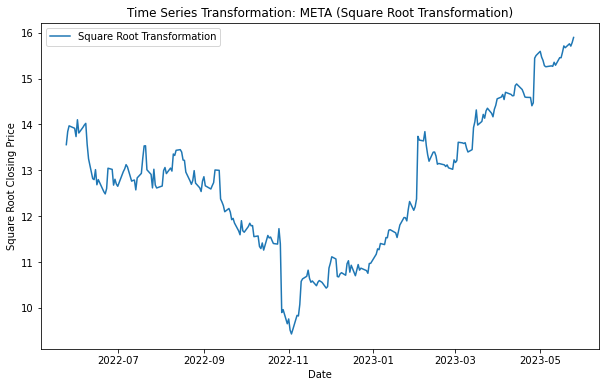

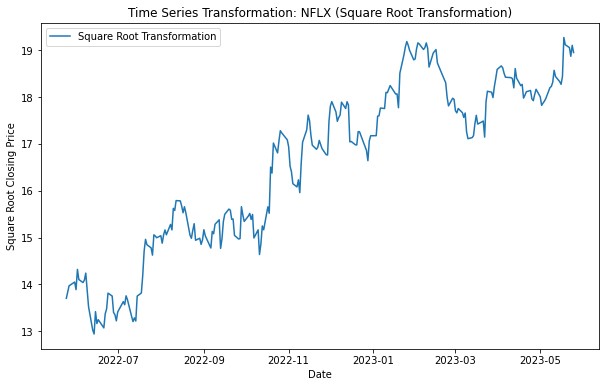

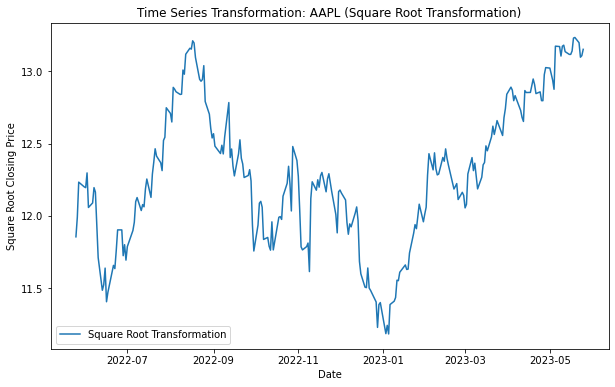

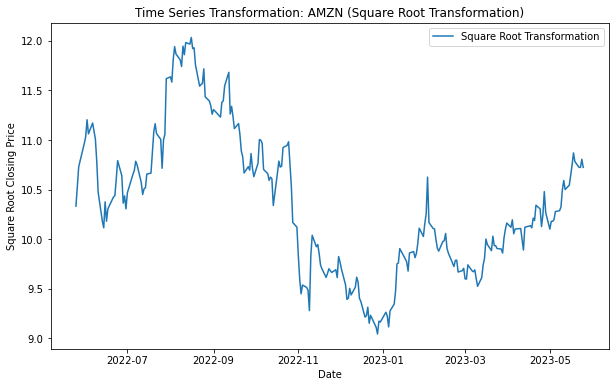

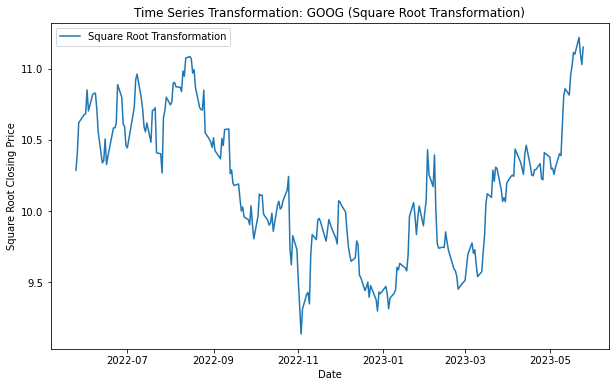

In [88]:
# Perform the square root transformation for each company second
for ticker in company_tickers:
    # Select the closing price of the current company for the time series analysis
    time_series = df_filtered[df_filtered['Ticker'] == ticker]['Close']
    
    # Perform the square root transformation on the series
    sqrt_transformed = np.sqrt(time_series)
    
    # Plot the square root-transformed series
    plt.figure(figsize=(10, 6))
    plt.plot(sqrt_transformed, label='Square Root Transformation')
    plt.title(f'Time Series Transformation: {ticker} (Square Root Transformation)')
    plt.xlabel('Date')
    plt.ylabel('Square Root Closing Price')
    plt.legend()
    plt.show();

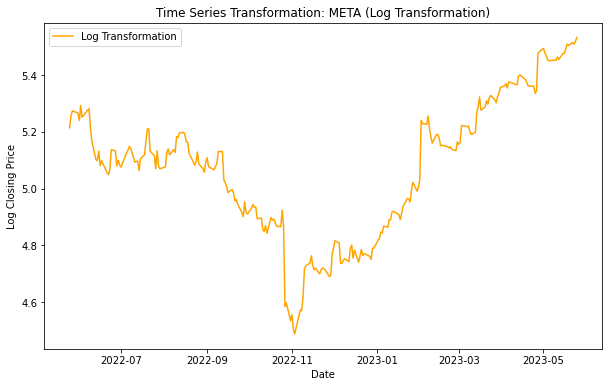

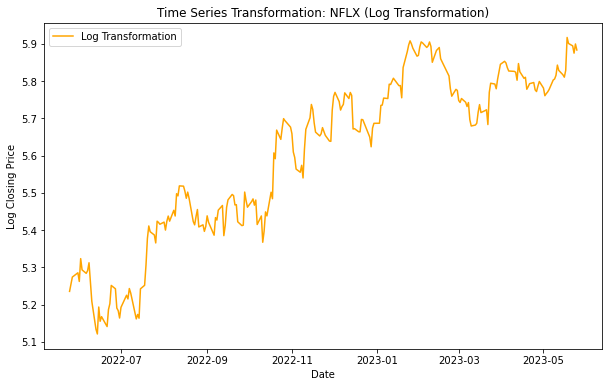

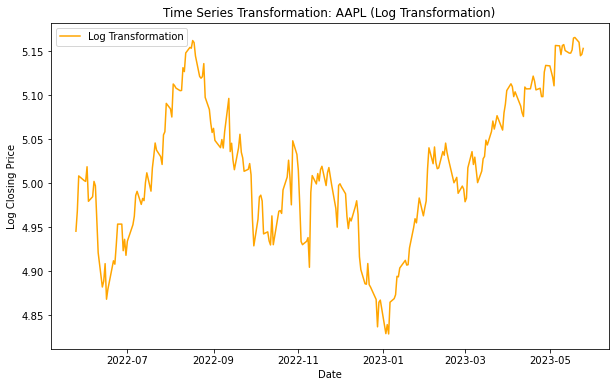

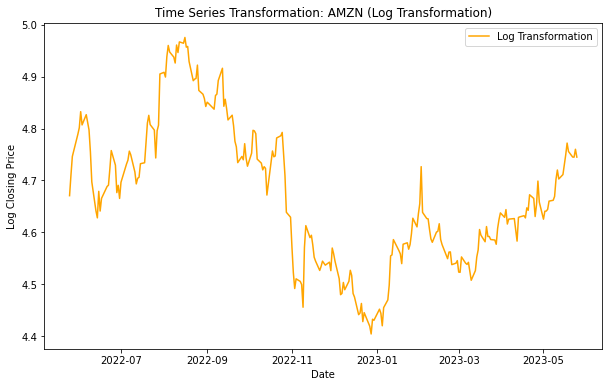

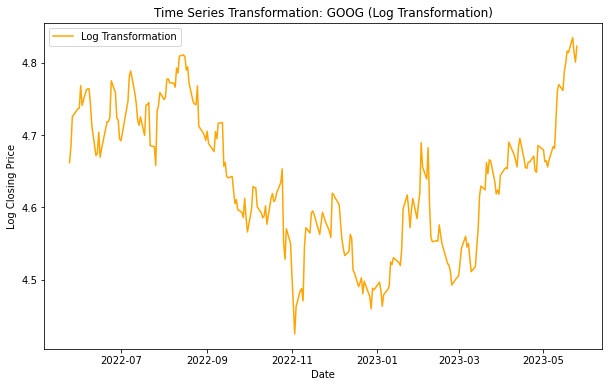

In [91]:
# Perform the log transformation for each company first
for ticker in company_tickers:
    # Select the closing price of the current company for the time series analysis
    time_series = df_filtered[df_filtered['Ticker'] == ticker]['Close']
    
    # Perform the log transformation on the series
    log_transformed = np.log(time_series)
    
    # Plot the log-transformed series with yellow color
    plt.figure(figsize=(10, 6))
    plt.plot(log_transformed, label='Log Transformation', color='orange')
    plt.title(f'Time Series Transformation: {ticker} (Log Transformation)')
    plt.xlabel('Date')
    plt.ylabel('Log Closing Price')
    plt.legend()
    plt.show();

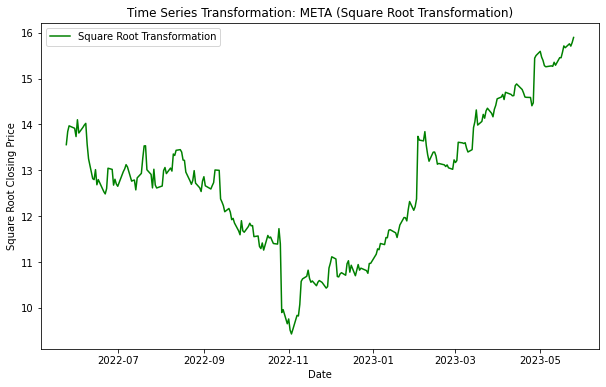

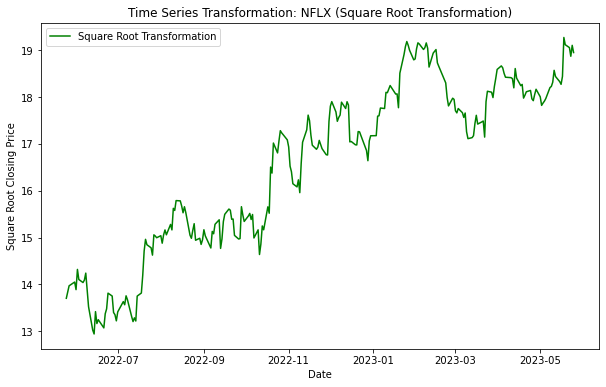

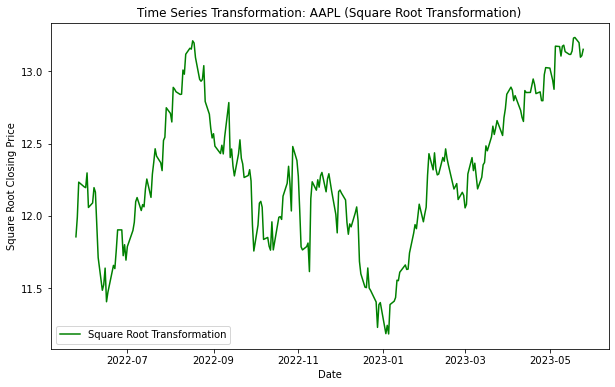

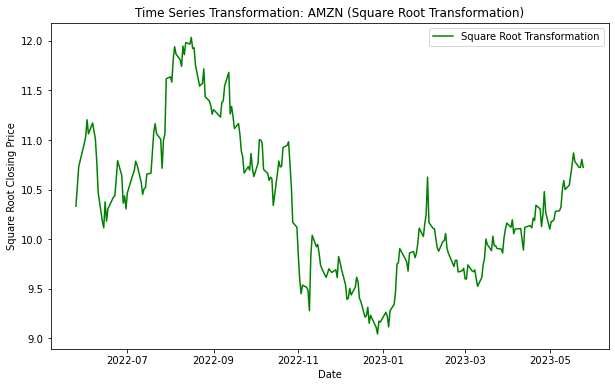

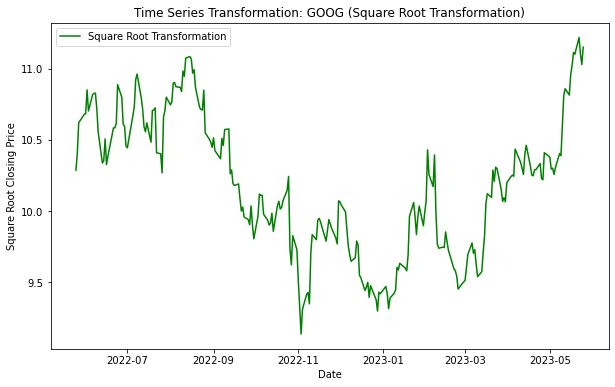

In [90]:
# Perform the square root transformation for each company second
for ticker in company_tickers:
    # Select the closing price of the current company for the time series analysis
    time_series = df_filtered[df_filtered['Ticker'] == ticker]['Close']
    
    # Perform the square root transformation on the series
    sqrt_transformed = np.sqrt(time_series)
    
    # Plot the square root-transformed series with green color
    plt.figure(figsize=(10, 6))
    plt.plot(sqrt_transformed, label='Square Root Transformation', color='green')
    plt.title(f'Time Series Transformation: {ticker} (Square Root Transformation)')
    plt.xlabel('Date')
    plt.ylabel('Square Root Closing Price')
    plt.legend()
    plt.show()


### Exponential Transformation

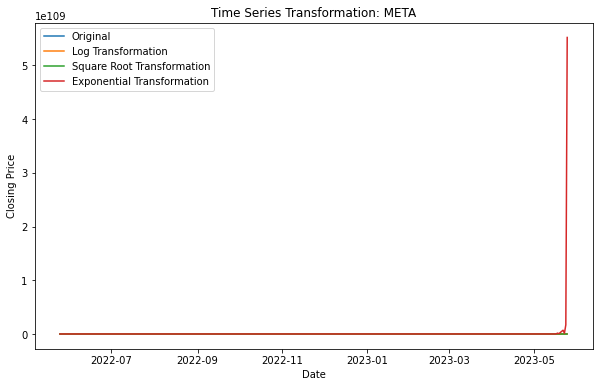

Augmented Dickey-Fuller Test: META (Original)
Test Statistic: -0.08397756678813963
P-value: 0.9510112293168292
Critical Values: {'1%': -3.4566744514553016, '5%': -2.8731248767783426, '10%': -2.5729436702592023}

Augmented Dickey-Fuller Test: META (Log Transformation)
Test Statistic: -0.5373801433696621
P-value: 0.8845133066718971
Critical Values: {'1%': -3.4566744514553016, '5%': -2.8731248767783426, '10%': -2.5729436702592023}

Augmented Dickey-Fuller Test: META (Square Root Transformation)
Test Statistic: -0.313014654413256
P-value: 0.9236407349981895
Critical Values: {'1%': -3.4566744514553016, '5%': -2.8731248767783426, '10%': -2.5729436702592023}

Augmented Dickey-Fuller Test: META (Exponential Transformation)
Test Statistic: -58.02538043389944
P-value: 0.0
Critical Values: {'1%': -3.4583663275730476, '5%': -2.8738660999177132, '10%': -2.5733390785693766}


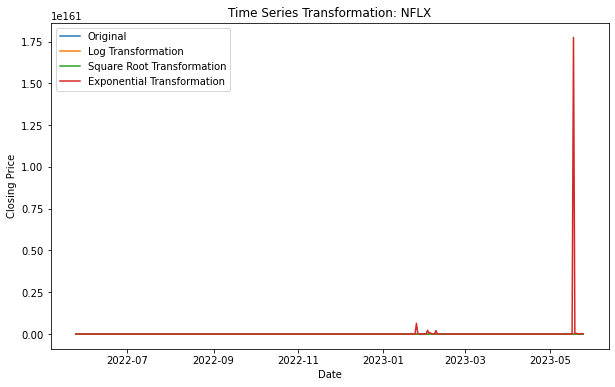

Augmented Dickey-Fuller Test: NFLX (Original)
Test Statistic: -1.2244236999620313
P-value: 0.663002011181012
Critical Values: {'1%': -3.4566744514553016, '5%': -2.8731248767783426, '10%': -2.5729436702592023}

Augmented Dickey-Fuller Test: NFLX (Log Transformation)
Test Statistic: -1.3801165246329612
P-value: 0.5917705185716103
Critical Values: {'1%': -3.4566744514553016, '5%': -2.8731248767783426, '10%': -2.5729436702592023}

Augmented Dickey-Fuller Test: NFLX (Square Root Transformation)
Test Statistic: -1.2974006649038576
P-value: 0.6303606719964235
Critical Values: {'1%': -3.4566744514553016, '5%': -2.8731248767783426, '10%': -2.5729436702592023}

Augmented Dickey-Fuller Test: NFLX (Exponential Transformation)
Test Statistic: -0.0
P-value: 0.958532086060056
Critical Values: {'1%': -3.4566744514553016, '5%': -2.8731248767783426, '10%': -2.5729436702592023}


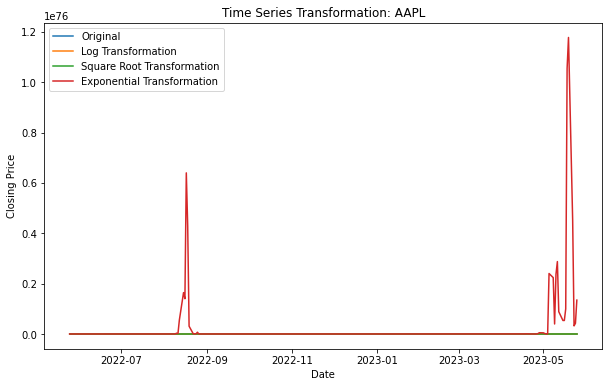

Augmented Dickey-Fuller Test: AAPL (Original)
Test Statistic: -1.6004307698499853
P-value: 0.4833770754254152
Critical Values: {'1%': -3.4566744514553016, '5%': -2.8731248767783426, '10%': -2.5729436702592023}

Augmented Dickey-Fuller Test: AAPL (Log Transformation)
Test Statistic: -1.6853700704482841
P-value: 0.43866558199256067
Critical Values: {'1%': -3.4566744514553016, '5%': -2.8731248767783426, '10%': -2.5729436702592023}

Augmented Dickey-Fuller Test: AAPL (Square Root Transformation)
Test Statistic: -1.6423532737109234
P-value: 0.46103140508938745
Critical Values: {'1%': -3.4566744514553016, '5%': -2.8731248767783426, '10%': -2.5729436702592023}

Augmented Dickey-Fuller Test: AAPL (Exponential Transformation)
Test Statistic: -0.06507762330217788
P-value: 0.9528077458003724
Critical Values: {'1%': -3.457664132155201, '5%': -2.8735585105960224, '10%': -2.5731749894132916}


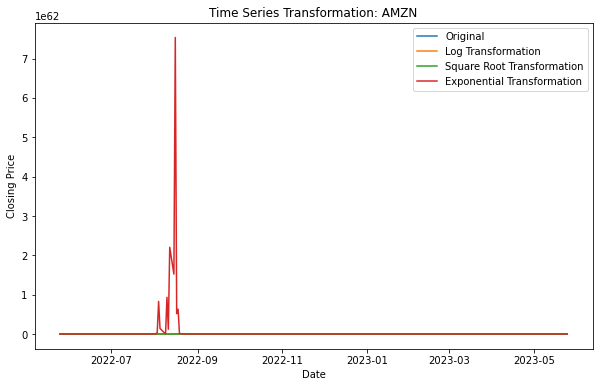

Augmented Dickey-Fuller Test: AMZN (Original)
Test Statistic: -1.5608273069809186
P-value: 0.5032354859654384
Critical Values: {'1%': -3.4566744514553016, '5%': -2.8731248767783426, '10%': -2.5729436702592023}

Augmented Dickey-Fuller Test: AMZN (Log Transformation)
Test Statistic: -1.558832784020486
P-value: 0.5042332034337323
Critical Values: {'1%': -3.4566744514553016, '5%': -2.8731248767783426, '10%': -2.5729436702592023}

Augmented Dickey-Fuller Test: AMZN (Square Root Transformation)
Test Statistic: -1.5569134834848783
P-value: 0.5051930309521453
Critical Values: {'1%': -3.4566744514553016, '5%': -2.8731248767783426, '10%': -2.5729436702592023}

Augmented Dickey-Fuller Test: AMZN (Exponential Transformation)
Test Statistic: -6.983719305558956
P-value: 8.068731925589991e-10
Critical Values: {'1%': -3.4568881317725864, '5%': -2.8732185133016057, '10%': -2.5729936189738876}


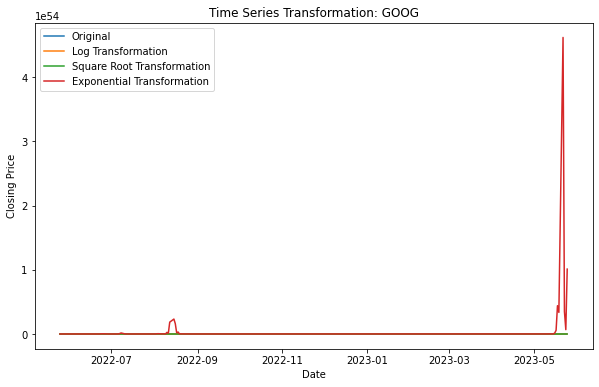

Augmented Dickey-Fuller Test: GOOG (Original)
Test Statistic: -1.4907880552888804
P-value: 0.538063334663326
Critical Values: {'1%': -3.4566744514553016, '5%': -2.8731248767783426, '10%': -2.5729436702592023}

Augmented Dickey-Fuller Test: GOOG (Log Transformation)
Test Statistic: -1.562198640203795
P-value: 0.5025493484226131
Critical Values: {'1%': -3.4566744514553016, '5%': -2.8731248767783426, '10%': -2.5729436702592023}

Augmented Dickey-Fuller Test: GOOG (Square Root Transformation)
Test Statistic: -1.525324219266421
P-value: 0.5209486964622965
Critical Values: {'1%': -3.4566744514553016, '5%': -2.8731248767783426, '10%': -2.5729436702592023}

Augmented Dickey-Fuller Test: GOOG (Exponential Transformation)
Test Statistic: -2.315291269152797
P-value: 0.16708364977233836
Critical Values: {'1%': -3.4569962781990573, '5%': -2.8732659015936024, '10%': -2.573018897632674}


In [93]:
# Set the desired time range
start_date = pd.to_datetime('2022-05-01')
end_date = pd.to_datetime('2023-05-31')

# Filter the DataFrame for the desired time range
df_filtered = df.loc[(df.index >= start_date) & (df.index <= end_date)]

# Define the list of company tickers
company_tickers = ['META', 'NFLX', 'AAPL', 'AMZN', 'GOOG']  # Replace with actual company tickers

# Iterate over each company ticker
for ticker in company_tickers:
    # Select the closing price of the current company for the time series analysis
    time_series = df_filtered[df_filtered['Ticker'] == ticker]['Close']
    
    # Perform the Augmented Dickey-Fuller test on the original series
    result_original = adfuller(time_series)
    
    # Perform the log transformation on the series
    log_transformed = np.log(time_series)
    
    # Perform the square root transformation on the series
    sqrt_transformed = np.sqrt(time_series)
    
    # Perform the exponential transformation on the series
    exp_transformed = np.exp(time_series)
    
    # Perform the Augmented Dickey-Fuller test on the log-transformed series
    result_log = adfuller(log_transformed)
    
    # Perform the Augmented Dickey-Fuller test on the square root-transformed series
    result_sqrt = adfuller(sqrt_transformed)
    
    # Perform the Augmented Dickey-Fuller test on the exponential-transformed series
    result_exp = adfuller(exp_transformed)
    
    # Plot the original, log-transformed, square root-transformed, and exponential-transformed series
    plt.figure(figsize=(10, 6))
    plt.plot(time_series, label='Original')
    plt.plot(log_transformed, label='Log Transformation')
    plt.plot(sqrt_transformed, label='Square Root Transformation')
    plt.plot(exp_transformed, label='Exponential Transformation')
    plt.title(f'Time Series Transformation: {ticker}')
    plt.xlabel('Date')
    plt.ylabel('Closing Price')
    plt.legend()
    plt.show()
    
    # Print the Augmented Dickey-Fuller test results
    print(f'Augmented Dickey-Fuller Test: {ticker} (Original)')
    print(f'Test Statistic: {result_original[0]}')
    print(f'P-value: {result_original[1]}')
    print(f'Critical Values: {result_original[4]}')
    print('')

    print(f'Augmented Dickey-Fuller Test: {ticker} (Log Transformation)')
    print(f'Test Statistic: {result_log[0]}')
    print(f'P-value: {result_log[1]}')
    print(f'Critical Values: {result_log[4]}')
    print('')

    print(f'Augmented Dickey-Fuller Test: {ticker} (Square Root Transformation)')
    print(f'Test Statistic: {result_sqrt[0]}')
    print(f'P-value: {result_sqrt[1]}')
    print(f'Critical Values: {result_sqrt[4]}')
    print('')

    print(f'Augmented Dickey-Fuller Test: {ticker} (Exponential Transformation)')
    print(f'Test Statistic: {result_exp[0]}')
    print(f'P-value: {result_exp[1]}')
    print(f'Critical Values: {result_exp[4]}')

### Box-Cox Transformation

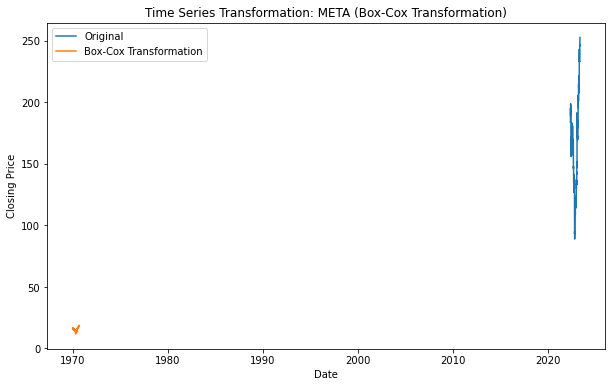

Box-Cox Transformation Parameter: 0.37816861939940666
Augmented Dickey-Fuller Test: META (Box-Cox Transformation)
Test Statistic: -0.36822868682591886
P-value: 0.9152698318589212
Critical Values: {'1%': -3.4566744514553016, '5%': -2.8731248767783426, '10%': -2.5729436702592023}



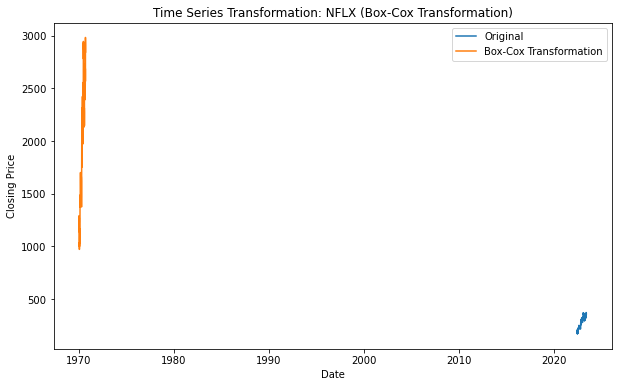

Box-Cox Transformation Parameter: 1.4104159505289011
Augmented Dickey-Fuller Test: NFLX (Box-Cox Transformation)
Test Statistic: -1.1739171877557986
P-value: 0.6847140592844974
Critical Values: {'1%': -3.4566744514553016, '5%': -2.8731248767783426, '10%': -2.5729436702592023}



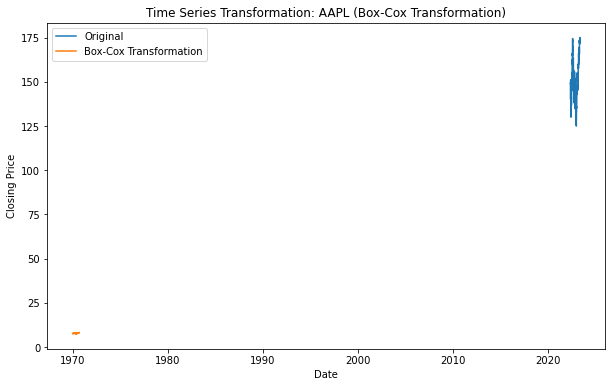

Box-Cox Transformation Parameter: 0.1632655634809526
Augmented Dickey-Fuller Test: AAPL (Box-Cox Transformation)
Test Statistic: -1.6712116928372374
P-value: 0.44600276167231745
Critical Values: {'1%': -3.4566744514553016, '5%': -2.8731248767783426, '10%': -2.5729436702592023}



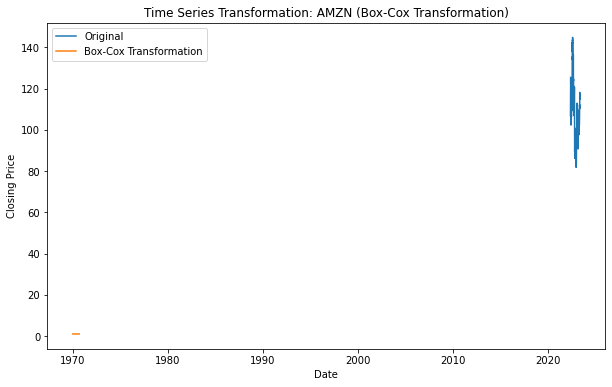

Box-Cox Transformation Parameter: -0.9801578008056149
Augmented Dickey-Fuller Test: AMZN (Box-Cox Transformation)
Test Statistic: -1.5802215820325531
P-value: 0.4935207796802573
Critical Values: {'1%': -3.4566744514553016, '5%': -2.8731248767783426, '10%': -2.5729436702592023}



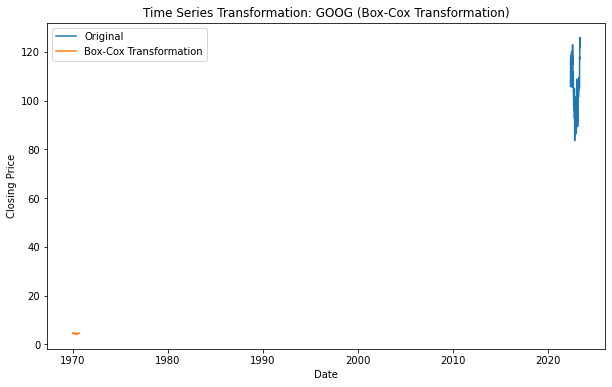

Box-Cox Transformation Parameter: -0.02178384134993197
Augmented Dickey-Fuller Test: GOOG (Box-Cox Transformation)
Test Statistic: -1.563858470488504
P-value: 0.5017186951017858
Critical Values: {'1%': -3.4566744514553016, '5%': -2.8731248767783426, '10%': -2.5729436702592023}



In [94]:
from scipy.stats import boxcox

# Set the desired time range
start_date = pd.to_datetime('2022-05-01')
end_date = pd.to_datetime('2023-05-31')

# Filter the DataFrame for the desired time range
df_filtered = df.loc[(df.index >= start_date) & (df.index <= end_date)]

# Define the list of company tickers
company_tickers = ['META', 'NFLX', 'AAPL', 'AMZN', 'GOOG']  # Replace with actual company tickers

# Iterate over each company ticker
for ticker in company_tickers:
    # Select the closing price of the current company for the time series analysis
    time_series = df_filtered[df_filtered['Ticker'] == ticker]['Close']
    
    # Perform the Box-Cox transformation on the series
    transformed_series, lam = boxcox(time_series)
    
    # Perform the Augmented Dickey-Fuller test on the transformed series
    result_transformed = adfuller(transformed_series)
    
    # Plot the original and transformed series
    plt.figure(figsize=(10, 6))
    plt.plot(time_series, label='Original')
    plt.plot(transformed_series, label='Box-Cox Transformation')
    plt.title(f'Time Series Transformation: {ticker} (Box-Cox Transformation)')
    plt.xlabel('Date')
    plt.ylabel('Closing Price')
    plt.legend()
    plt.show()
    
    # Print the Box-Cox transformation parameter and the Augmented Dickey-Fuller test result
    print(f'Box-Cox Transformation Parameter: {lam}')
    print(f'Augmented Dickey-Fuller Test: {ticker} (Box-Cox Transformation)')
    print(f'Test Statistic: {result_transformed[0]}')
    print(f'P-value: {result_transformed[1]}')
    print(f'Critical Values: {result_transformed[4]}')
    print('')

### DIfference Transformation

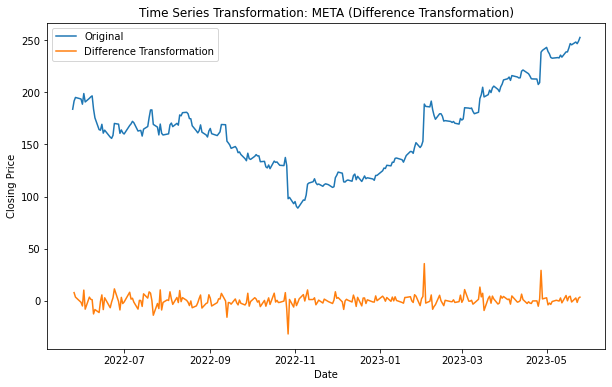

Augmented Dickey-Fuller Test: META (Difference Transformation)
Test Statistic: -15.246116330586773
P-value: 5.083856842796495e-28
Critical Values: {'1%': -3.456780859712, '5%': -2.8731715065600003, '10%': -2.572968544}



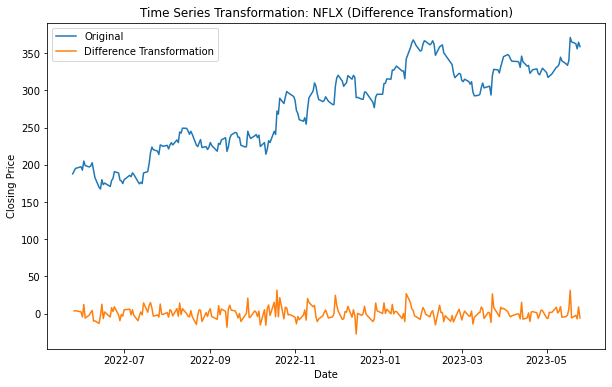

Augmented Dickey-Fuller Test: NFLX (Difference Transformation)
Test Statistic: -15.719410763010485
P-value: 1.3295654463733393e-28
Critical Values: {'1%': -3.456780859712, '5%': -2.8731715065600003, '10%': -2.572968544}



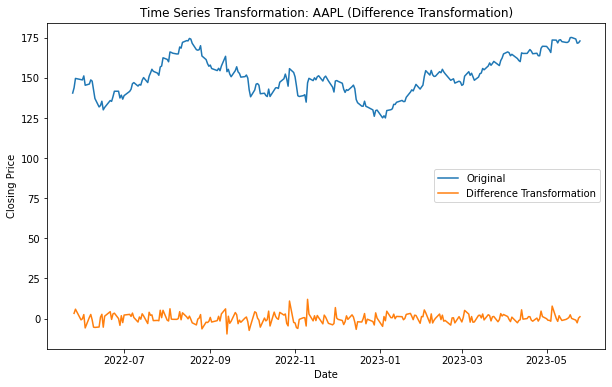

Augmented Dickey-Fuller Test: AAPL (Difference Transformation)
Test Statistic: -7.267716493673049
P-value: 1.618549115461378e-10
Critical Values: {'1%': -3.457215237265747, '5%': -2.873361841566324, '10%': -2.5730700760129555}



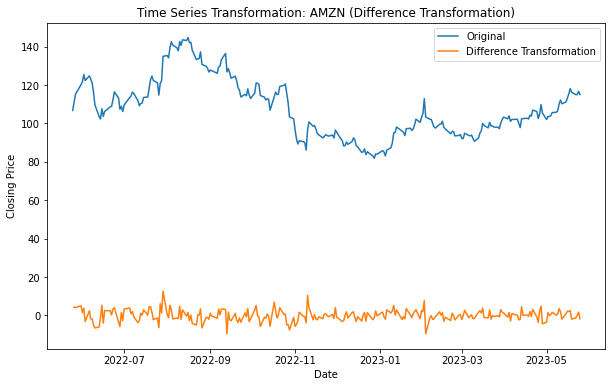

Augmented Dickey-Fuller Test: AMZN (Difference Transformation)
Test Statistic: -14.937675142434172
P-value: 1.3370220286932093e-27
Critical Values: {'1%': -3.456780859712, '5%': -2.8731715065600003, '10%': -2.572968544}



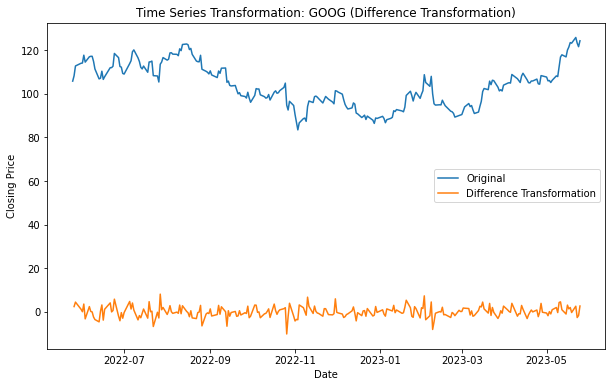

Augmented Dickey-Fuller Test: GOOG (Difference Transformation)
Test Statistic: -15.435935095402286
P-value: 2.9071084316404296e-28
Critical Values: {'1%': -3.456780859712, '5%': -2.8731715065600003, '10%': -2.572968544}



In [95]:
# Set the desired time range
start_date = pd.to_datetime('2022-05-01')
end_date = pd.to_datetime('2023-05-31')

# Filter the DataFrame for the desired time range
df_filtered = df.loc[(df.index >= start_date) & (df.index <= end_date)]

# Define the list of company tickers
company_tickers = ['META', 'NFLX', 'AAPL', 'AMZN', 'GOOG']  # Replace with actual company tickers

# Iterate over each company ticker
for ticker in company_tickers:
    # Select the closing price of the current company for the time series analysis
    time_series = df_filtered[df_filtered['Ticker'] == ticker]['Close']
    
    # Perform the first difference transformation on the series
    diff_series = time_series.diff().dropna()
    
    # Perform the Augmented Dickey-Fuller test on the differenced series
    result_diff = adfuller(diff_series)
    
    # Plot the original and differenced series
    plt.figure(figsize=(10, 6))
    plt.plot(time_series, label='Original')
    plt.plot(diff_series, label='Difference Transformation')
    plt.title(f'Time Series Transformation: {ticker} (Difference Transformation)')
    plt.xlabel('Date')
    plt.ylabel('Closing Price')
    plt.legend()
    plt.show()
    
    # Print the Augmented Dickey-Fuller test result
    print(f'Augmented Dickey-Fuller Test: {ticker} (Difference Transformation)')
    print(f'Test Statistic: {result_diff[0]}')
    print(f'P-value: {result_diff[1]}')
    print(f'Critical Values: {result_diff[4]}')
    print('')

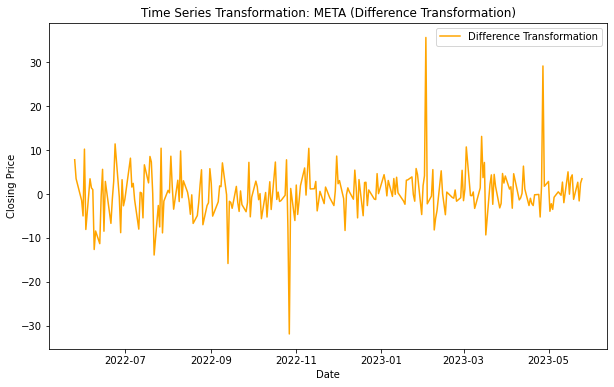

Augmented Dickey-Fuller Test: META (Difference Transformation)
Test Statistic: -15.246116330586773
P-value: 5.083856842796495e-28
Critical Values: {'1%': -3.456780859712, '5%': -2.8731715065600003, '10%': -2.572968544}



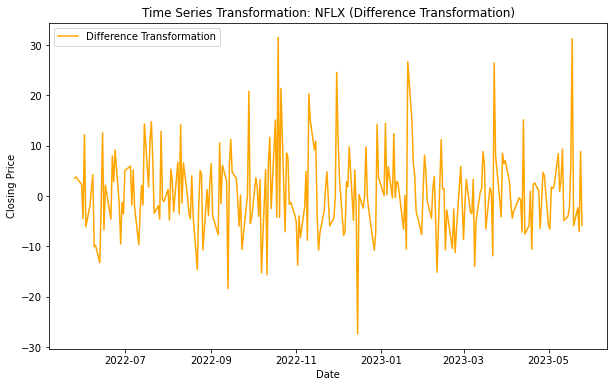

Augmented Dickey-Fuller Test: NFLX (Difference Transformation)
Test Statistic: -15.719410763010485
P-value: 1.3295654463733393e-28
Critical Values: {'1%': -3.456780859712, '5%': -2.8731715065600003, '10%': -2.572968544}



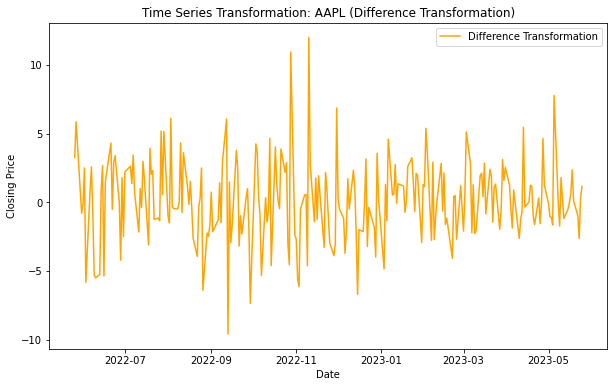

Augmented Dickey-Fuller Test: AAPL (Difference Transformation)
Test Statistic: -7.267716493673049
P-value: 1.618549115461378e-10
Critical Values: {'1%': -3.457215237265747, '5%': -2.873361841566324, '10%': -2.5730700760129555}



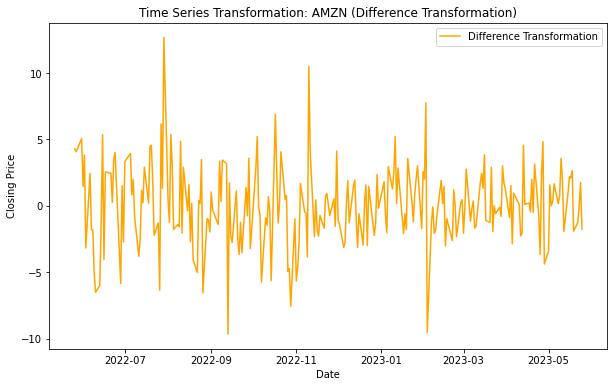

Augmented Dickey-Fuller Test: AMZN (Difference Transformation)
Test Statistic: -14.937675142434172
P-value: 1.3370220286932093e-27
Critical Values: {'1%': -3.456780859712, '5%': -2.8731715065600003, '10%': -2.572968544}



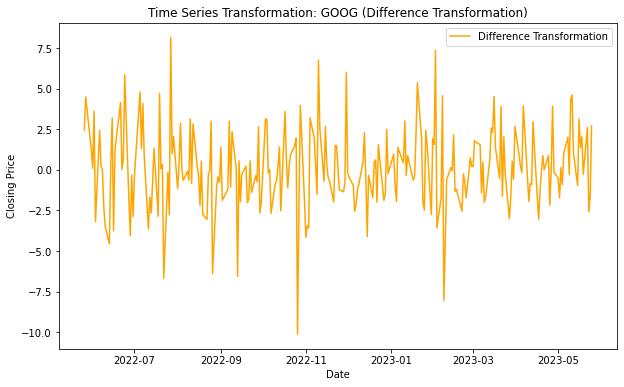

Augmented Dickey-Fuller Test: GOOG (Difference Transformation)
Test Statistic: -15.435935095402286
P-value: 2.9071084316404296e-28
Critical Values: {'1%': -3.456780859712, '5%': -2.8731715065600003, '10%': -2.572968544}



In [97]:
# Set the desired time range
start_date = pd.to_datetime('2022-05-01')
end_date = pd.to_datetime('2023-05-31')

# Filter the DataFrame for the desired time range
df_filtered = df.loc[(df.index >= start_date) & (df.index <= end_date)]

# Define the list of company tickers
company_tickers = ['META', 'NFLX', 'AAPL', 'AMZN', 'GOOG']  # Replace with actual company tickers

# Iterate over each company ticker
for ticker in company_tickers:
    # Select the closing price of the current company for the time series analysis
    time_series = df_filtered[df_filtered['Ticker'] == ticker]['Close']
    
    # Perform the first difference transformation on the series
    diff_series = time_series.diff().dropna()
    
    # Plot the differenced series
    plt.figure(figsize=(10, 6))
    plt.plot(diff_series, label='Difference Transformation', color='orange')
    plt.title(f'Time Series Transformation: {ticker} (Difference Transformation)')
    plt.xlabel('Date')
    plt.ylabel('Closing Price')
    plt.legend()
    plt.show()
    
    # Perform the Augmented Dickey-Fuller test on the differenced series
    result_diff = adfuller(diff_series)
    
    # Print the Augmented Dickey-Fuller test result
    print(f'Augmented Dickey-Fuller Test: {ticker} (Difference Transformation)')
    print(f'Test Statistic: {result_diff[0]}')
    print(f'P-value: {result_diff[1]}')
    print(f'Critical Values: {result_diff[4]}')
    print('');

## Model

### Train-Test Split

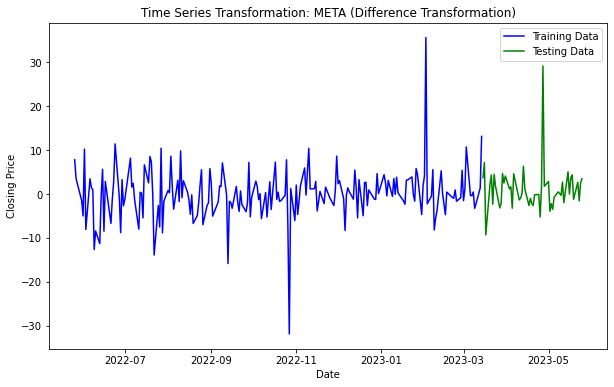

Augmented Dickey-Fuller Test: META (Difference Transformation)
Test Statistic: -15.246116330586773
P-value: 5.083856842796495e-28
Critical Values: {'1%': -3.456780859712, '5%': -2.8731715065600003, '10%': -2.572968544}



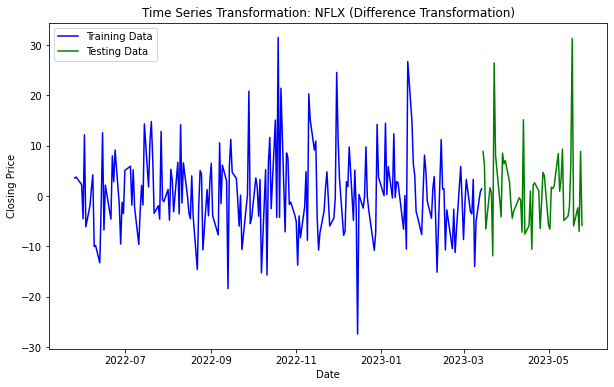

Augmented Dickey-Fuller Test: NFLX (Difference Transformation)
Test Statistic: -15.719410763010485
P-value: 1.3295654463733393e-28
Critical Values: {'1%': -3.456780859712, '5%': -2.8731715065600003, '10%': -2.572968544}



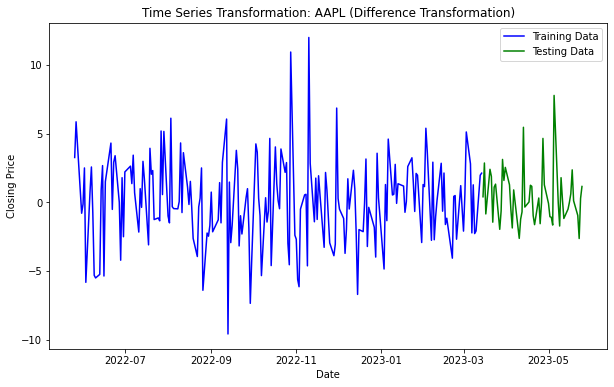

Augmented Dickey-Fuller Test: AAPL (Difference Transformation)
Test Statistic: -7.267716493673049
P-value: 1.618549115461378e-10
Critical Values: {'1%': -3.457215237265747, '5%': -2.873361841566324, '10%': -2.5730700760129555}



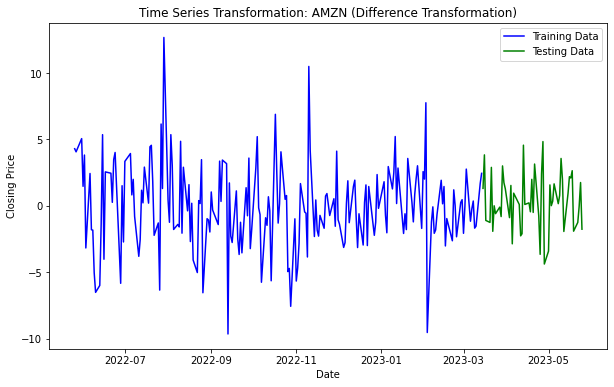

Augmented Dickey-Fuller Test: AMZN (Difference Transformation)
Test Statistic: -14.937675142434172
P-value: 1.3370220286932093e-27
Critical Values: {'1%': -3.456780859712, '5%': -2.8731715065600003, '10%': -2.572968544}



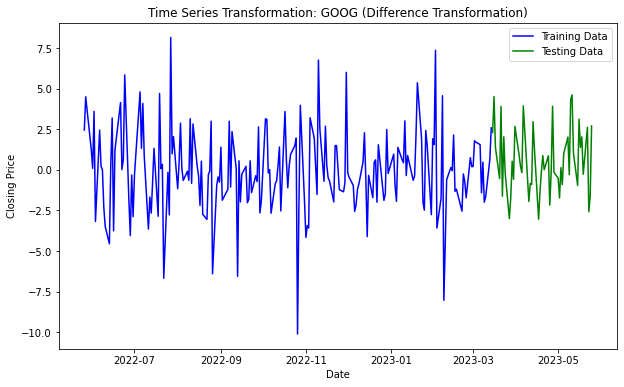

Augmented Dickey-Fuller Test: GOOG (Difference Transformation)
Test Statistic: -15.435935095402286
P-value: 2.9071084316404296e-28
Critical Values: {'1%': -3.456780859712, '5%': -2.8731715065600003, '10%': -2.572968544}



In [98]:
from sklearn.model_selection import train_test_split

# Set the desired time range
start_date = pd.to_datetime('2022-05-01')
end_date = pd.to_datetime('2023-05-31')

# Filter the DataFrame for the desired time range
df_filtered = df.loc[(df.index >= start_date) & (df.index <= end_date)]

# Define the list of company tickers
company_tickers = ['META', 'NFLX', 'AAPL', 'AMZN', 'GOOG']  # Replace with actual company tickers

# Iterate over each company ticker
for ticker in company_tickers:
    # Select the closing price of the current company for the time series analysis
    time_series = df_filtered[df_filtered['Ticker'] == ticker]['Close']
    
    # Perform the first difference transformation on the series
    diff_series = time_series.diff().dropna()
    
    # Split the data into training and testing sets
    train_data, test_data = train_test_split(diff_series, test_size=0.2, shuffle=False)
    # Adjust the test_size and shuffle parameters based on your needs
    
    # Plot the differenced series
    plt.figure(figsize=(10, 6))
    plt.plot(train_data, label='Training Data', color='blue')
    plt.plot(test_data, label='Testing Data', color='green')
    plt.title(f'Time Series Transformation: {ticker} (Difference Transformation)')
    plt.xlabel('Date')
    plt.ylabel('Closing Price')
    plt.legend()
    plt.show()
    
    # Perform the Augmented Dickey-Fuller test on the differenced series
    result_diff = adfuller(diff_series)
    
    # Print the Augmented Dickey-Fuller test result
    print(f'Augmented Dickey-Fuller Test: {ticker} (Difference Transformation)')
    print(f'Test Statistic: {result_diff[0]}')
    print(f'P-value: {result_diff[1]}')
    print(f'Critical Values: {result_diff[4]}')
    print('')

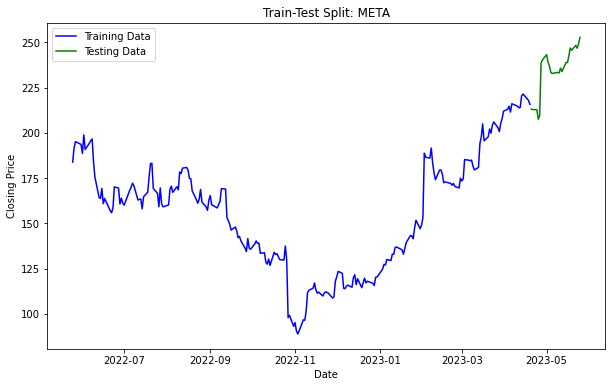

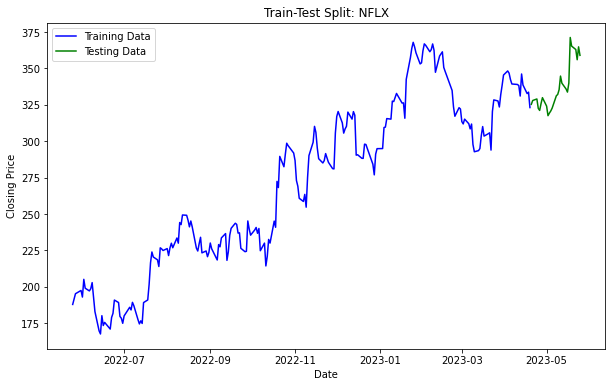

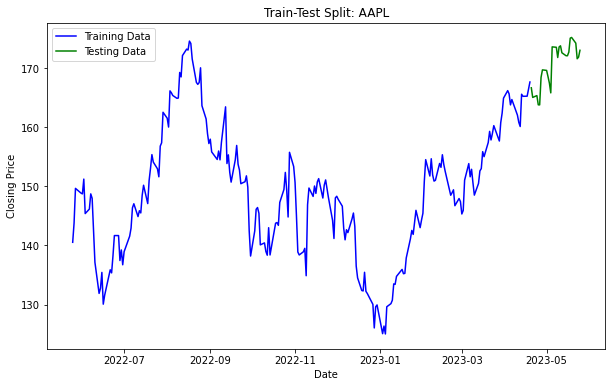

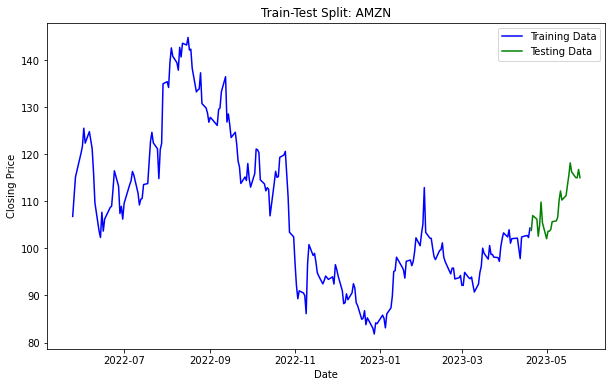

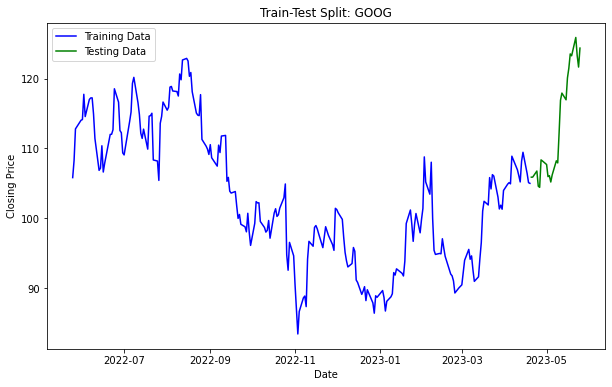

In [100]:
# Set the desired time range
start_date = pd.to_datetime('2022-05-01')
end_date = pd.to_datetime('2023-05-31')

# Filter the DataFrame for the desired time range
df_filtered = df.loc[(df.index >= start_date) & (df.index <= end_date)]

# Define the list of company tickers
company_tickers = ['META', 'NFLX', 'AAPL', 'AMZN', 'GOOG']  # Replace with actual company tickers

# Iterate over each company ticker
for ticker in company_tickers:
    # Select the closing price of the current company for the time series analysis
    time_series = df_filtered[df_filtered['Ticker'] == ticker]['Close']
    
    # Split the data into training and testing sets
    train_data, test_data = train_test_split(time_series, test_size=0.1, shuffle=False)
    # Adjust the test_size and shuffle parameters based on your needs
    
    # Plot the training and testing data
    plt.figure(figsize=(10, 6))
    plt.plot(train_data, label='Training Data', color='blue')
    plt.plot(test_data, label='Testing Data', color='green')
    plt.title(f'Train-Test Split: {ticker}')
    plt.xlabel('Date')
    plt.ylabel('Closing Price')
    plt.legend()
    plt.show()
    
    # Perform any further modeling or analysis using the train_data and test_data
    # For example, you can train and evaluate an ARIMA or SARIMA model using these data sets
    # You can also perform other preprocessing steps or feature engineering as needed


### ARIMA Model

In [102]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

# Set the desired time range
start_date = pd.to_datetime('2022-05-01')
end_date = pd.to_datetime('2023-05-31')

# Filter the DataFrame for the desired time range
df_filtered = df.loc[(df.index >= start_date) & (df.index <= end_date)]

# Define the list of company tickers
company_tickers = ['META', 'NFLX', 'AAPL', 'AMZN', 'GOOG']  # Replace with actual company tickers

# Iterate over each company ticker
for ticker in company_tickers:
    # Select the closing price of the current company for the time series analysis
    time_series = df_filtered[df_filtered['Ticker'] == ticker]['Close']
    
    # Convert time_series to numpy array
    time_series_array = time_series.values
    
    # Split the data into training and testing sets
    train_data, test_data = train_test_split(time_series_array, test_size=0.1, shuffle=False)
    
    # Build the ARIMA model
    model = ARIMA(train_data, order=(1, 1, 1))  # Replace the order with appropriate values
    
    # Fit the ARIMA model to the training data
    model_fit = model.fit()
    
    # Make predictions on the testing data
    predictions = model_fit.predict(start=len(train_data), end=len(train_data) + len(test_data) - 1)
    
    # Convert predictions to pandas Series for plotting
    predictions_series = pd.Series(predictions, index=test_data.index)
    
    # Evaluate the model performance
    mse = mean_squared_error(test_data, predictions)
    rmse = np.sqrt(mse)
    
    # Plot the actual and predicted values
    plt.figure(figsize=(10, 6))
    plt.plot(test_data.index, test_data, label='Actual', color='blue')
    plt.plot(test_data.index, predictions_series, label='Predicted', color='red')
    plt.title(f'ARIMA Model: {ticker}')
    plt.xlabel('Date')
    plt.ylabel('Closing Price')
    plt.legend()
    plt.show()
    
    # Print the model performance metrics
    print(f'Mean Squared Error: {mse:.2f}')
    print(f'Root Mean Squared Error: {rmse:.2f}')
    print('')

AttributeError: 'numpy.ndarray' object has no attribute 'index'

In [103]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

# Set the desired time range
start_date = pd.to_datetime('2022-05-01')
end_date = pd.to_datetime('2023-05-31')

# Filter the DataFrame for the desired time range
df_filtered = df.loc[(df.index >= start_date) & (df.index <= end_date)]

# Define the list of company tickers
company_tickers = ['META', 'NFLX', 'AAPL', 'AMZN', 'GOOG']  # Replace with actual company tickers

# Iterate over each company ticker
for ticker in company_tickers:
    # Select the closing price of the current company for the time series analysis
    time_series = df_filtered[df_filtered['Ticker'] == ticker]['Close']
    
    # Convert time_series to numpy array
    time_series_array = time_series.values
    
    # Split the data into training and testing sets
    train_data, test_data = train_test_split(time_series_array, test_size=0.1, shuffle=False)
    
    # Create an index array for the test data
    test_index = pd.date_range(start=test_data.index[0], periods=len(test_data), freq='B')
    
    # Build the ARIMA model
    model = ARIMA(train_data, order=(1, 1, 1))  # Replace the order with appropriate values
    
    # Fit the ARIMA model to the training data
    model_fit = model.fit()
    
    # Make predictions on the testing data
    predictions = model_fit.predict(start=len(train_data), end=len(train_data) + len(test_data) - 1)
    
    # Convert predictions to pandas Series for plotting
    predictions_series = pd.Series(predictions, index=test_index)
    
    # Evaluate the model performance
    mse = mean_squared_error(test_data, predictions)
    rmse = np.sqrt(mse)
    
    # Plot the actual and predicted values
    plt.figure(figsize=(10, 6))
    plt.plot(test_index, test_data, label='Actual', color='blue')
    plt.plot(test_index, predictions_series, label='Predicted', color='red')
    plt.title(f'ARIMA Model: {ticker}')
    plt.xlabel('Date')
    plt.ylabel('Closing Price')
    plt.legend()
    plt.show()
    
    # Print the model performance metrics
    print(f'Mean Squared Error: {mse:.2f}')
    print(f'Root Mean Squared Error: {rmse:.2f}')
    print('')


AttributeError: 'numpy.ndarray' object has no attribute 'index'

ValueError: Multi-dimensional indexing (e.g. `obj[:, None]`) is no longer supported. Convert to a numpy array before indexing instead.

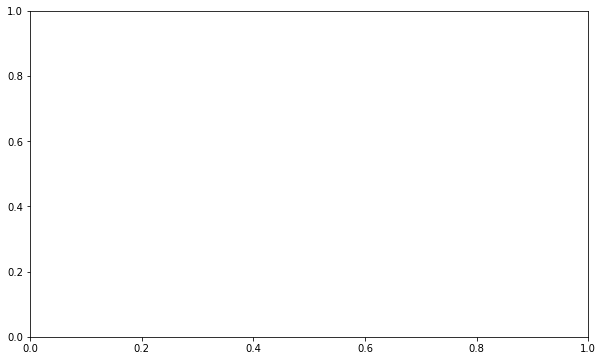

In [104]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

# Set the desired time range
start_date = pd.to_datetime('2022-05-01')
end_date = pd.to_datetime('2023-05-31')

# Filter the DataFrame for the desired time range
df_filtered = df.loc[(df.index >= start_date) & (df.index <= end_date)]

# Define the list of company tickers
company_tickers = ['META', 'NFLX', 'AAPL', 'AMZN', 'GOOG']  # Replace with actual company tickers

# Iterate over each company ticker
for ticker in company_tickers:
    # Select the closing price of the current company for the time series analysis
    time_series = df_filtered[df_filtered['Ticker'] == ticker]['Close']
    
    # Split the data into training and testing sets
    train_data, test_data = train_test_split(time_series, test_size=0.1, shuffle=False)
    
    # Build the ARIMA model
    model = ARIMA(train_data, order=(1, 1, 1))  # Replace the order with appropriate values
    
    # Fit the ARIMA model to the training data
    model_fit = model.fit()
    
    # Make predictions on the testing data
    predictions = model_fit.predict(start=len(train_data), end=len(train_data) + len(test_data) - 1)
    
    # Evaluate the model performance
    mse = mean_squared_error(test_data, predictions)
    rmse = np.sqrt(mse)
    
    # Plot the actual and predicted values
    plt.figure(figsize=(10, 6))
    plt.plot(test_data.index, test_data, label='Actual', color='blue')
    plt.plot(test_data.index, predictions, label='Predicted', color='red')
    plt.title(f'ARIMA Model: {ticker}')
    plt.xlabel('Date')
    plt.ylabel('Closing Price')
    plt.legend()
    plt.show()
    
    # Print the model performance metrics
    print(f'Mean Squared Error: {mse:.2f}')
    print(f'Root Mean Squared Error: {rmse:.2f}')
    print('')

ValueError: Multi-dimensional indexing (e.g. `obj[:, None]`) is no longer supported. Convert to a numpy array before indexing instead.

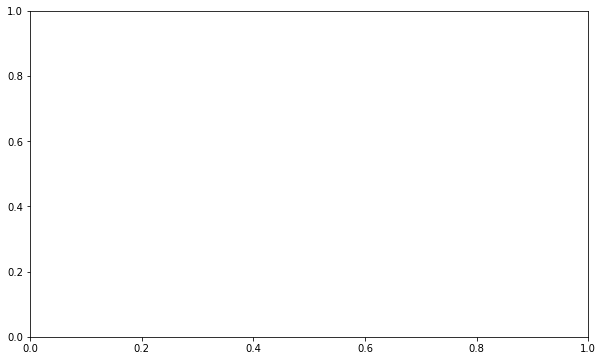

In [105]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

# Set the desired time range
start_date = pd.to_datetime('2022-05-01')
end_date = pd.to_datetime('2023-05-31')

# Filter the DataFrame for the desired time range
df_filtered = df.loc[(df.index >= start_date) & (df.index <= end_date)]

# Define the list of company tickers
company_tickers = ['META', 'NFLX', 'AAPL', 'AMZN', 'GOOG']  # Replace with actual company tickers

# Iterate over each company ticker
for ticker in company_tickers:
    # Select the closing price of the current company for the time series analysis
    time_series = df_filtered[df_filtered['Ticker'] == ticker]['Close']
    
    # Split the data into training and testing sets
    train_data, test_data = train_test_split(time_series, test_size=0.1, shuffle=False)
    
    # Build the ARIMA model
    model = ARIMA(train_data, order=(1, 1, 1))  # Replace the order with appropriate values
    
    # Fit the ARIMA model to the training data
    model_fit = model.fit()
    
    # Make predictions on the testing data
    predictions = model_fit.predict(start=len(train_data), end=len(train_data) + len(test_data) - 1)
    
    # Convert the index of test_data to a numpy array
    test_data_index = test_data.index.to_numpy()
    
    # Evaluate the model performance
    mse = mean_squared_error(test_data, predictions)
    rmse = np.sqrt(mse)
    
    # Plot the actual and predicted values
    plt.figure(figsize=(10, 6))
    plt.plot(test_data_index, test_data, label='Actual', color='blue')
    plt.plot(test_data_index, predictions, label='Predicted', color='red')
    plt.title(f'ARIMA Model: {ticker}')
    plt.xlabel('Date')
    plt.ylabel('Closing Price')
    plt.legend()
    plt.show()
    
    # Print the model performance metrics
    print(f'Mean Squared Error: {mse:.2f}')
    print(f'Root Mean Squared Error: {rmse:.2f}')
    print('')


## Evaluation

## Results

## Conclusion

## Next Steps